In [55]:
# bayes classifier over emotion dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from lib.dataset_utils import *
from sklearn.pipeline import Pipeline
from lib.plot_utils import plot_multilabel_confusion_heatmap, plot_score_barplot, get_scores_dict, custom_classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import os
import pickle
import string
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [56]:
DATASET = DatasetEnum.TwitterDataCleaned
# load dataset
train_df, val_df, test_df = load_dataset(DATASET)
LABELS = train_df.columns[1:]
TEXT_COLUMN = 'text'

In [57]:
def OVA_clf_analysis(train_df, val_df, classifier, text_col, label_cols):
    # flatten one hot encoded labels
    tr_labels = train_df[label_cols].idxmax(axis=1)
    # train classifier
    classifier.fit(train_df[text_col], tr_labels)
    # predict
    predictions_train = classifier.predict(train_df[text_col])
    predictions_val = classifier.predict(val_df[text_col])
    # multilabel binarizer for predictions
    mlb = MultiLabelBinarizer(classes=label_cols)
    predictions_train = mlb.fit_transform(predictions_train.reshape(-1, 1))
    predictions_val = mlb.fit_transform(predictions_val.reshape(-1, 1))
    # convert to dataframe
    predictions_train = pd.DataFrame(predictions_train, columns=label_cols)
    predictions_val = pd.DataFrame(predictions_val, columns=label_cols)
    # calculate metrics
    print("Train metrics")
    scores_dict = get_scores_dict(predictions_train, train_df, label_cols)
    custom_classification_report(scores_dict, label_cols)
    print("Val metrics")
    scores_dict = get_scores_dict(predictions_val, val_df, label_cols)
    custom_classification_report(scores_dict, label_cols)
    print("Train confusion matrix")
    plot_multilabel_confusion_heatmap(train_df[label_cols].to_numpy(), predictions_train.values, label_cols, label_cols, normalize=True)
    print("Val confusion matrix")
    plot_multilabel_confusion_heatmap(val_df[label_cols].to_numpy(), predictions_val.values, label_cols, label_cols, normalize=True)
    # bar plot over classes
    plot_score_barplot(train_df[label_cols], predictions_train, label_cols)
    plot_score_barplot(val_df[label_cols], predictions_val, label_cols)

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_content(text):
    # tokenize
    clean_text = nltk.word_tokenize(text)
    
    # pos tag
    clean_text = nltk.pos_tag(clean_text)
    TAG_MAP = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    clean_text = [(word, TAG_MAP.get(tag[0], 'n')) for word, tag in clean_text]

    # lemmatize
    clean_text = [lemmatizer.lemmatize(word, tag) for word, tag in clean_text]

    # remove punctuation marks
    clean_text = [w for w in clean_text if w not in string.punctuation]

    return ' '.join(clean_text)

def clean_df(df, text_col, out_col):
    df[out_col] = df[text_col].apply(clean_content)
    return df

In [5]:
CLEAN_TEXT_COLUMN = 'clean_text'
train_df = clean_df(train_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
val_df = clean_df(val_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
test_df = clean_df(test_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)

# TFIDF Decision tree

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                1.00                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                1.00                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

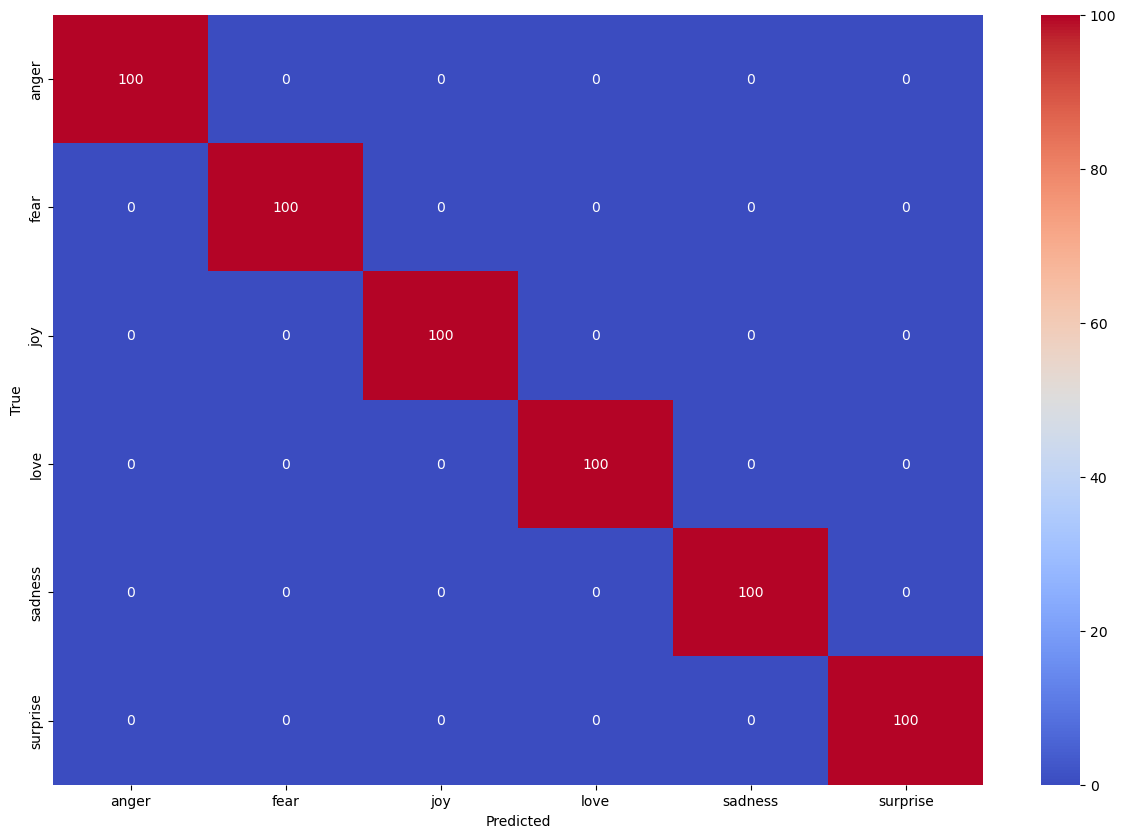

Val confusion matrix


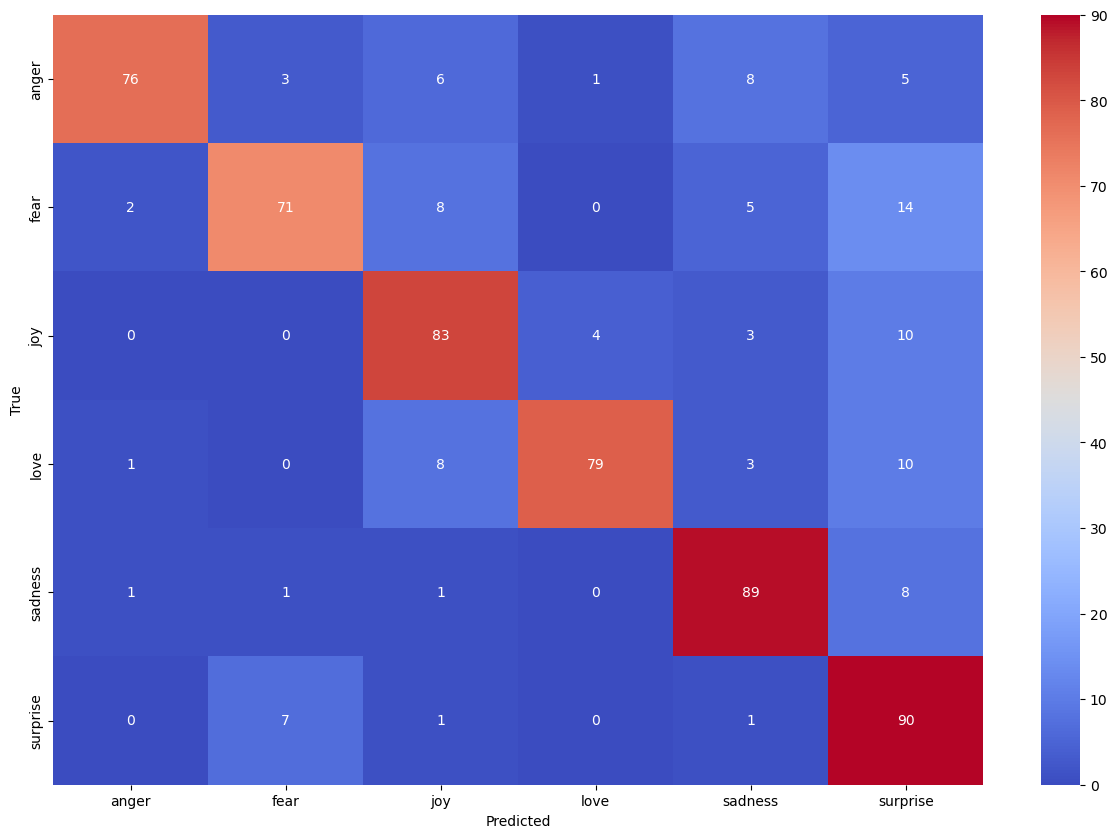

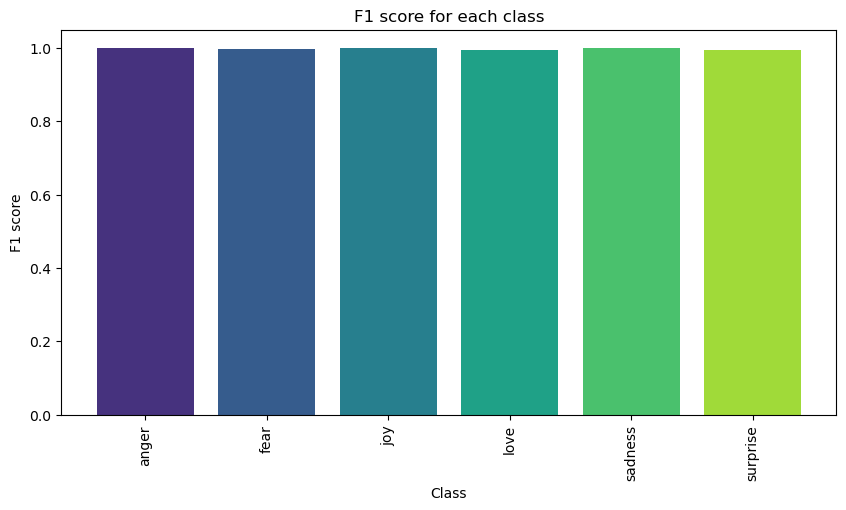

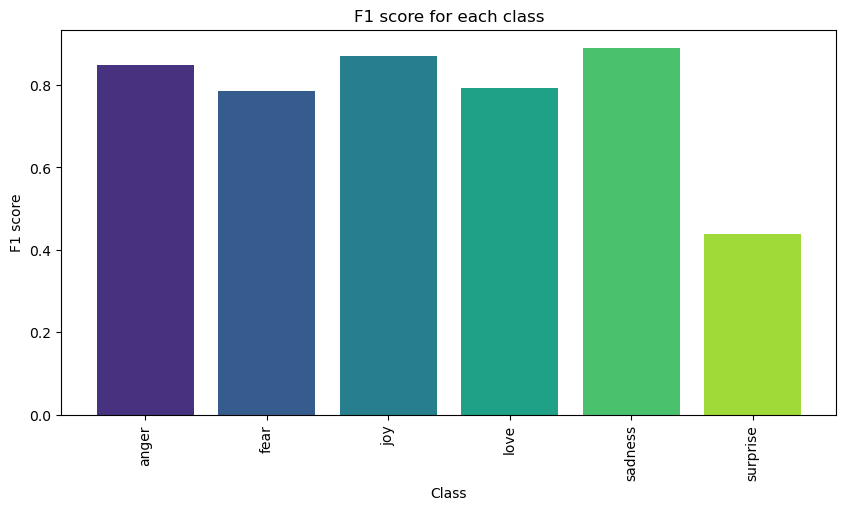

In [9]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

with cleaning

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                1.00                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                1.00                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

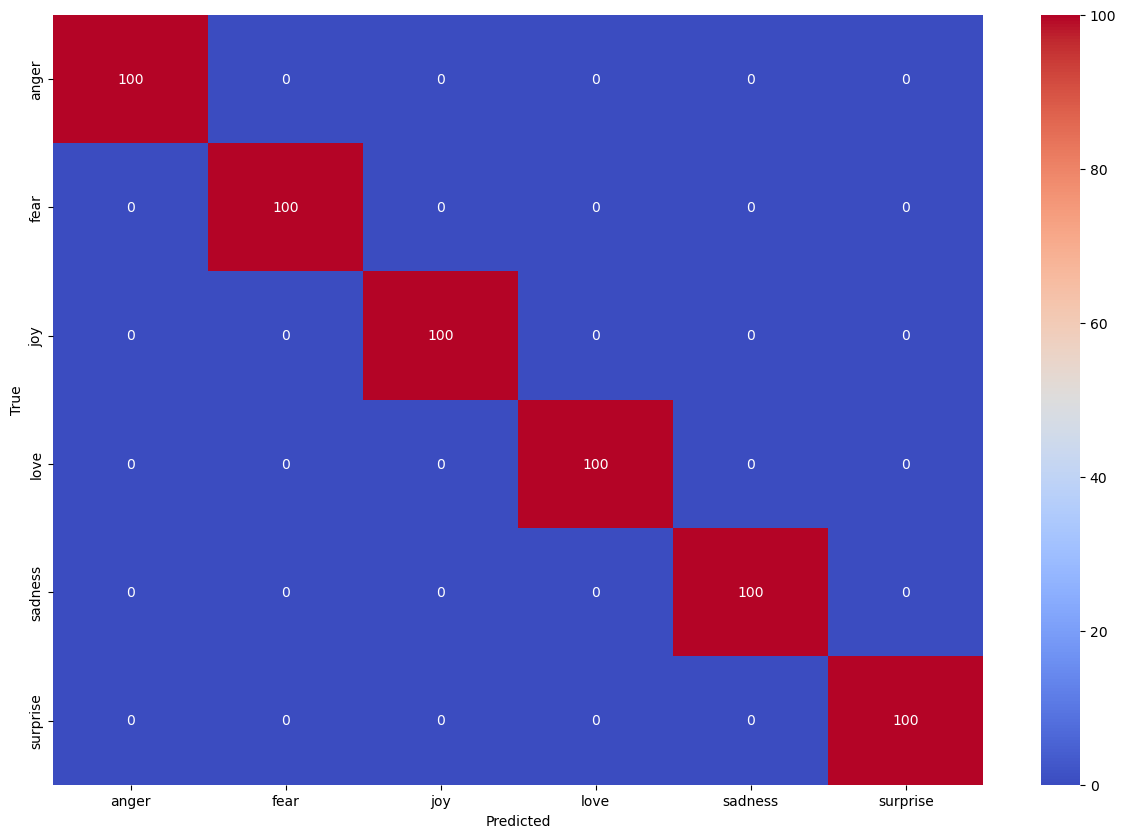

Val confusion matrix


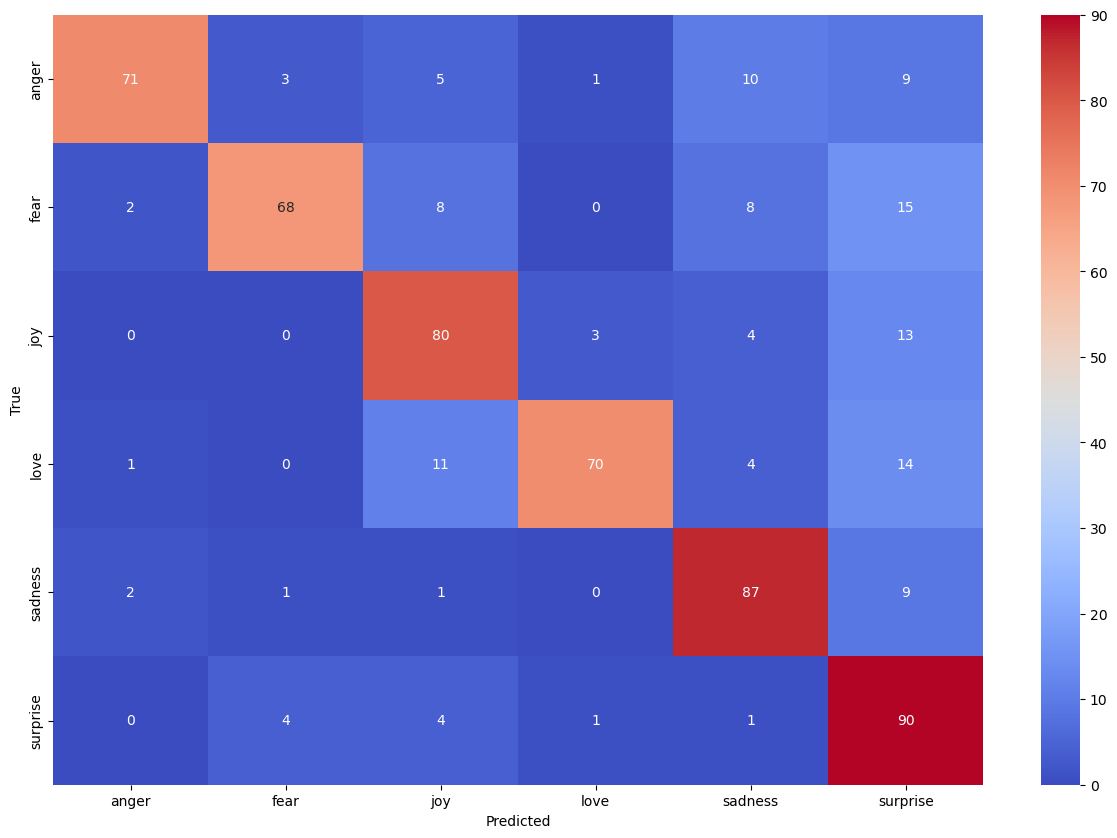

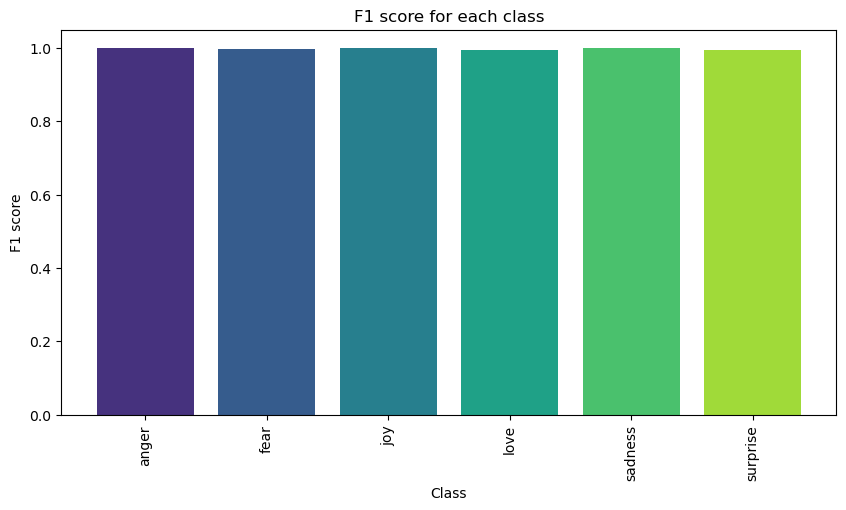

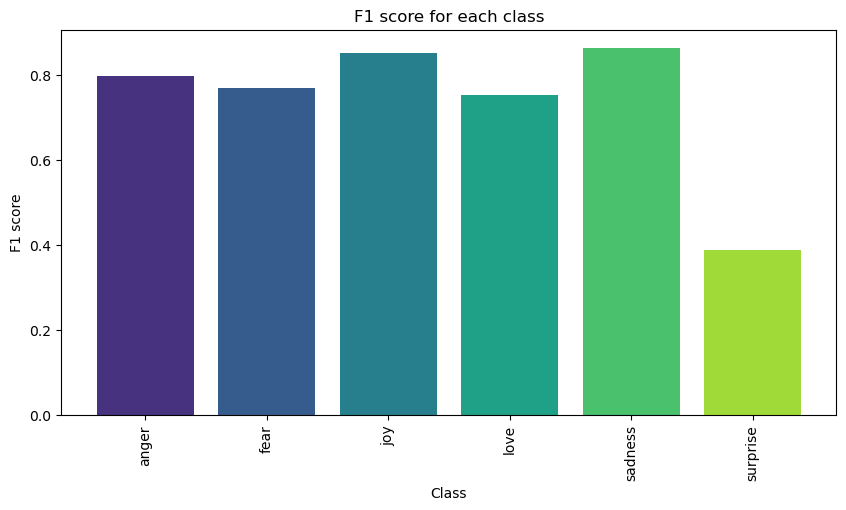

In [7]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
]))

OVA_clf_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

worse than uncleaned data

### Feature selection

Attempt with min df

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                1.00                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                1.00                0.99                0.98                 572
Macro avg                           1.00                1.00                1.00                0.99               1

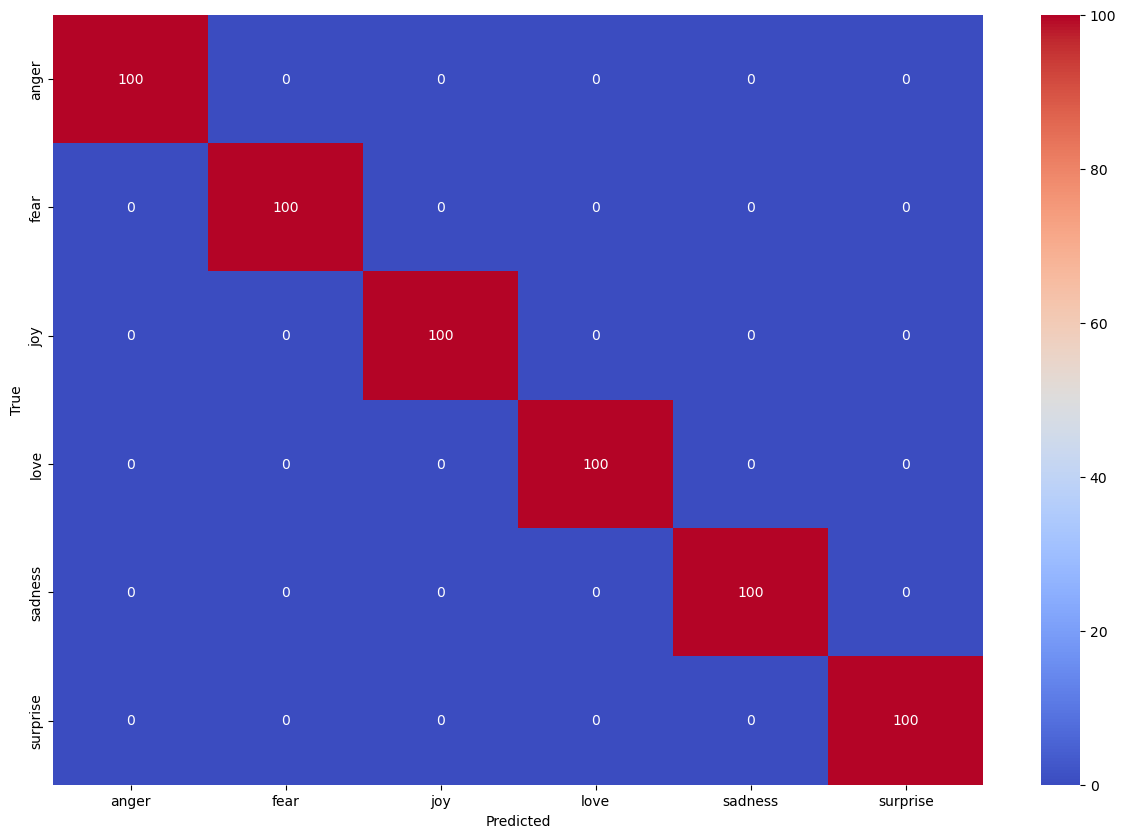

Val confusion matrix


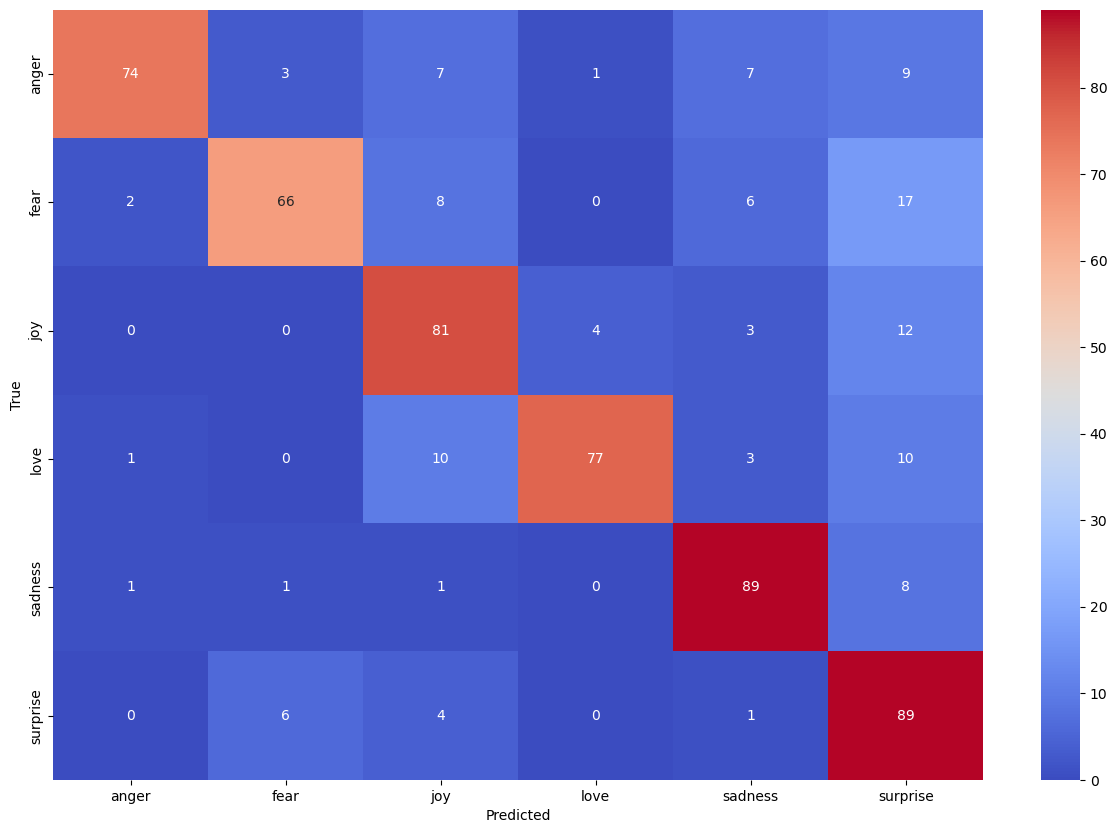

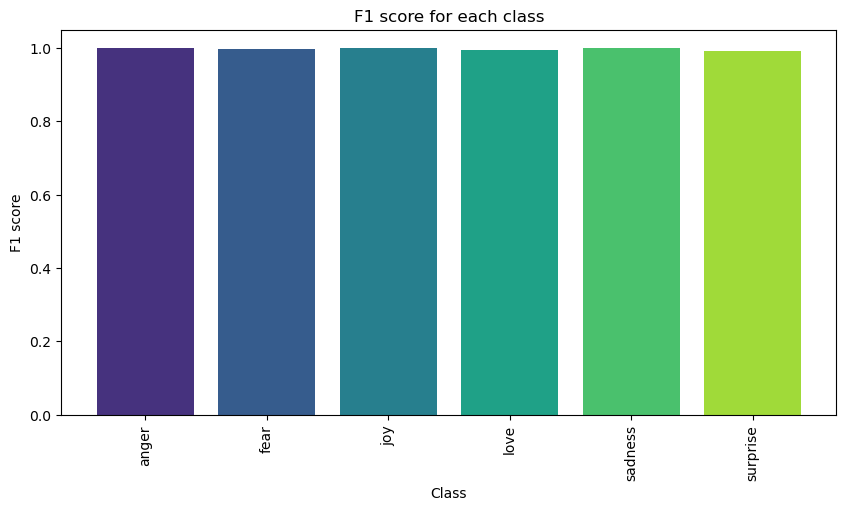

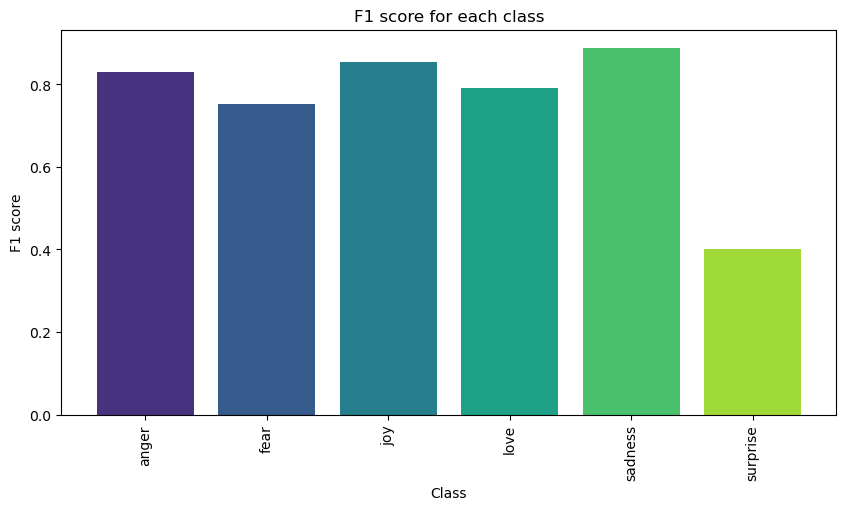

In [6]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5)),
    ('clf', DecisionTreeClassifier(random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

Attempt also with pmi based feature selection

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                0.99                2159
fear                                1.00                0.99                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                1.00                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.98                1.00                0.99                0.98                 572
Macro avg                           0.99                1.00                1.00                0.99               1

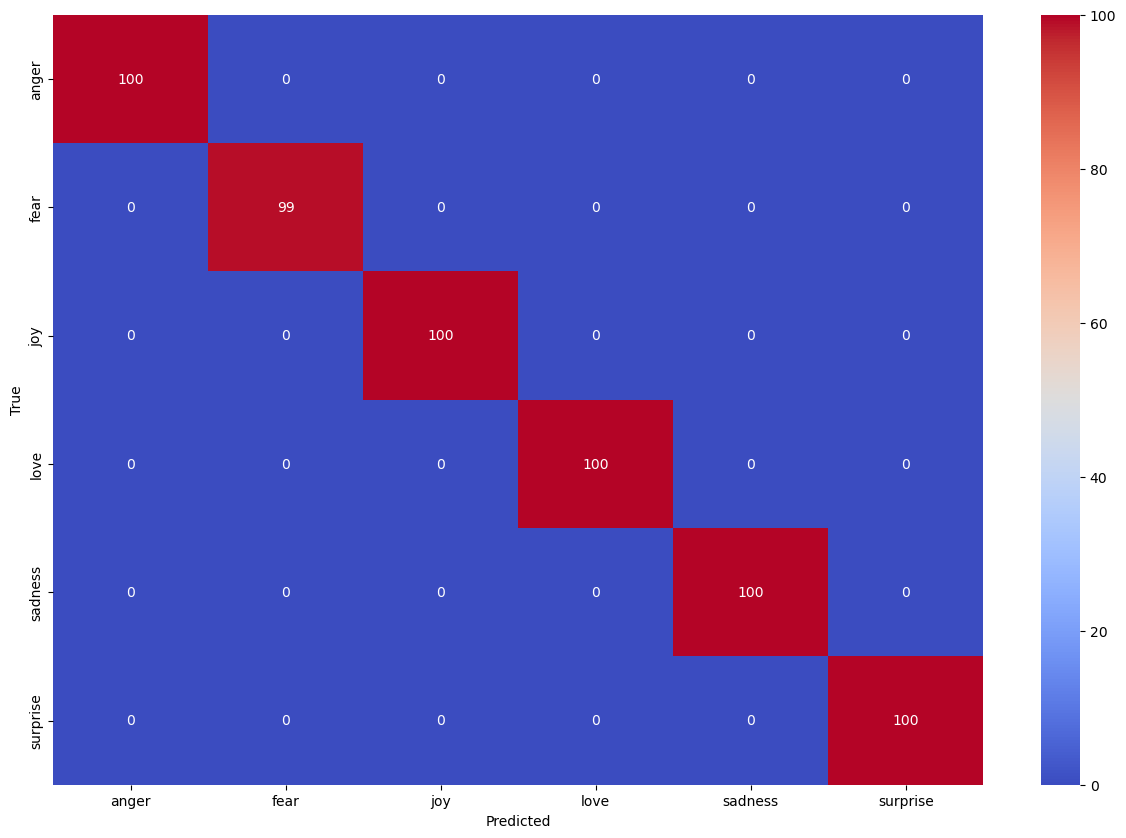

Val confusion matrix


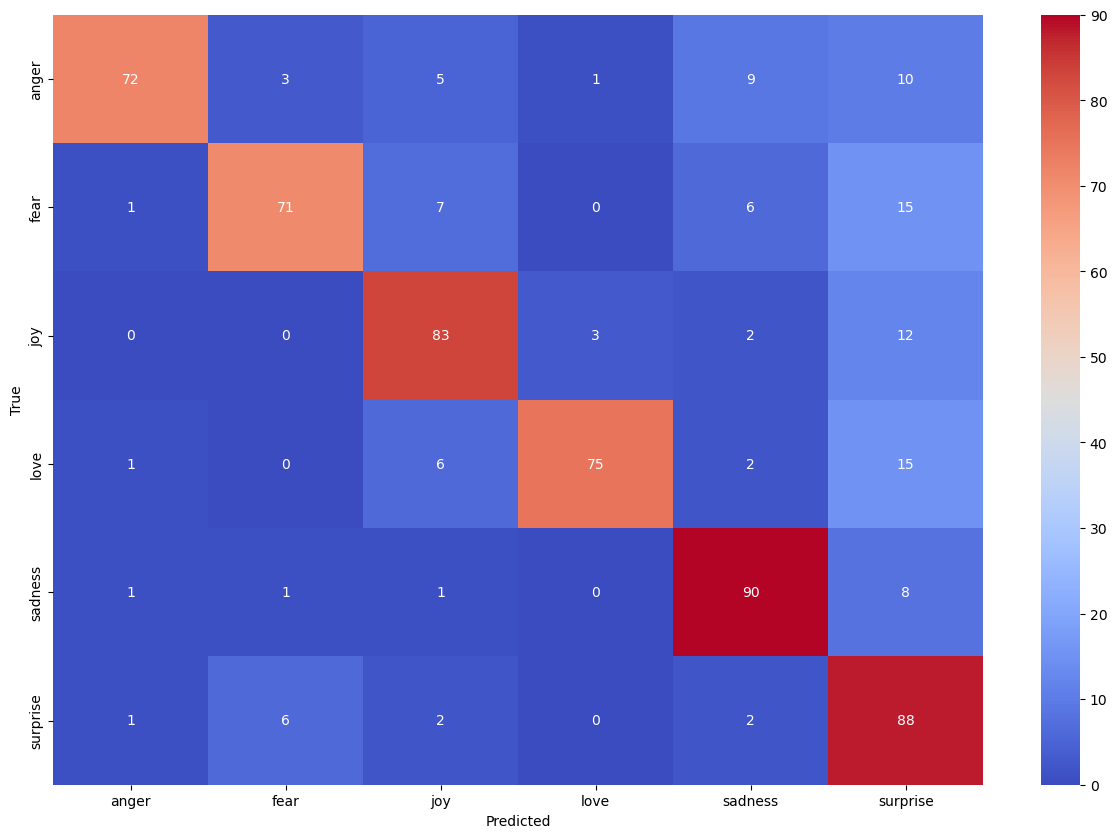

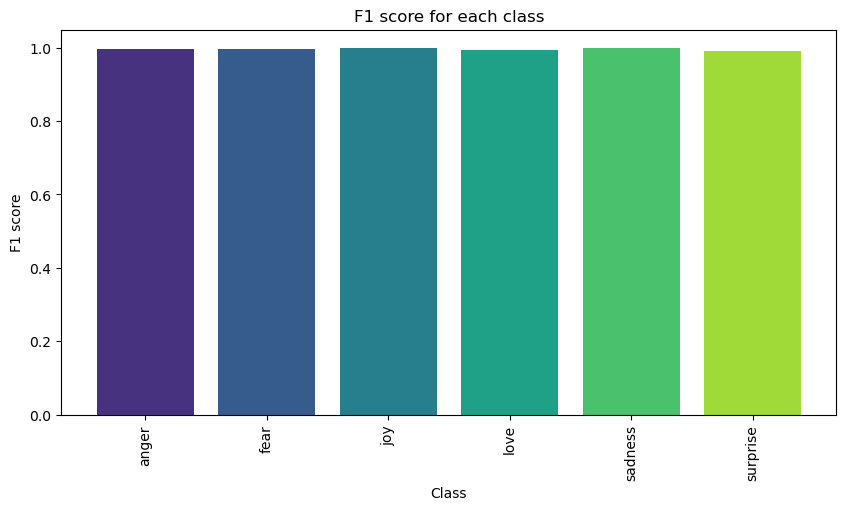

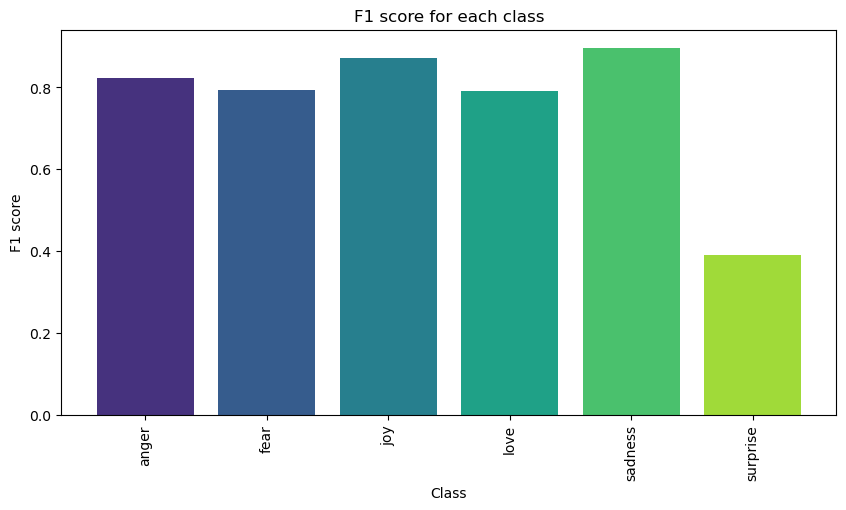

In [7]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=2)),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier(random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                1.00                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                1.00                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

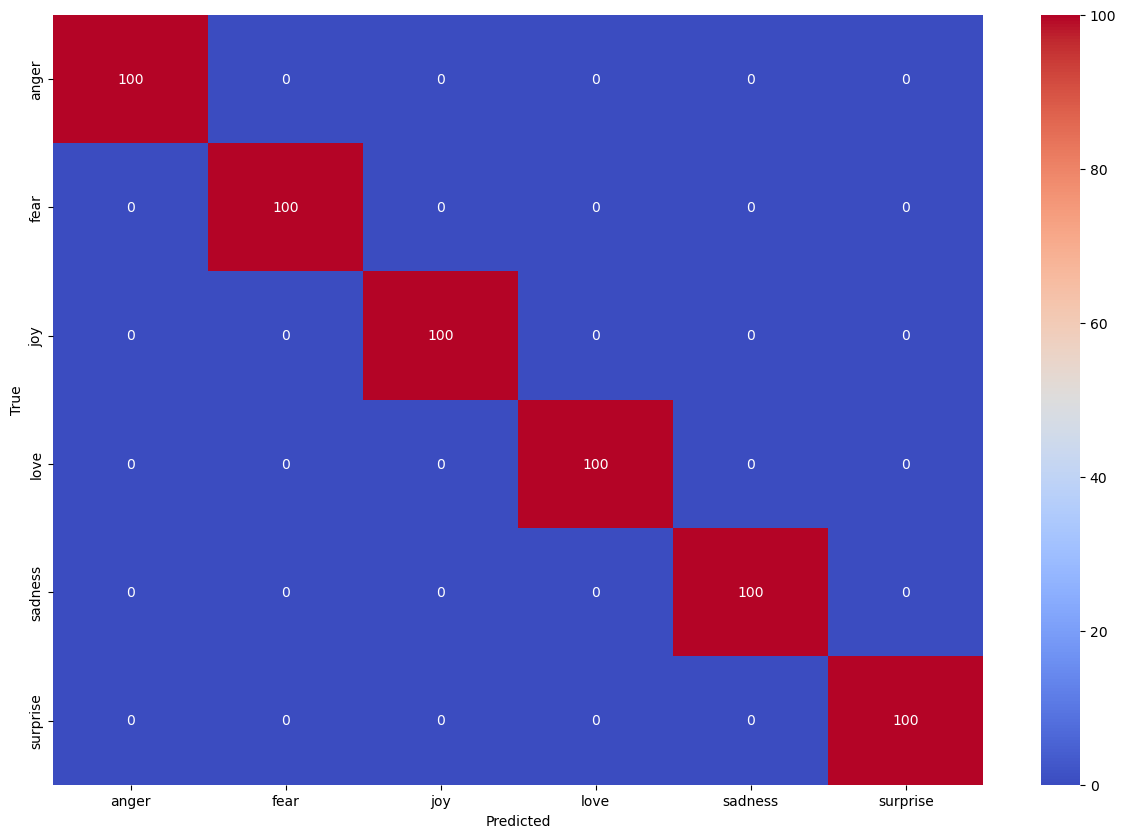

Val confusion matrix


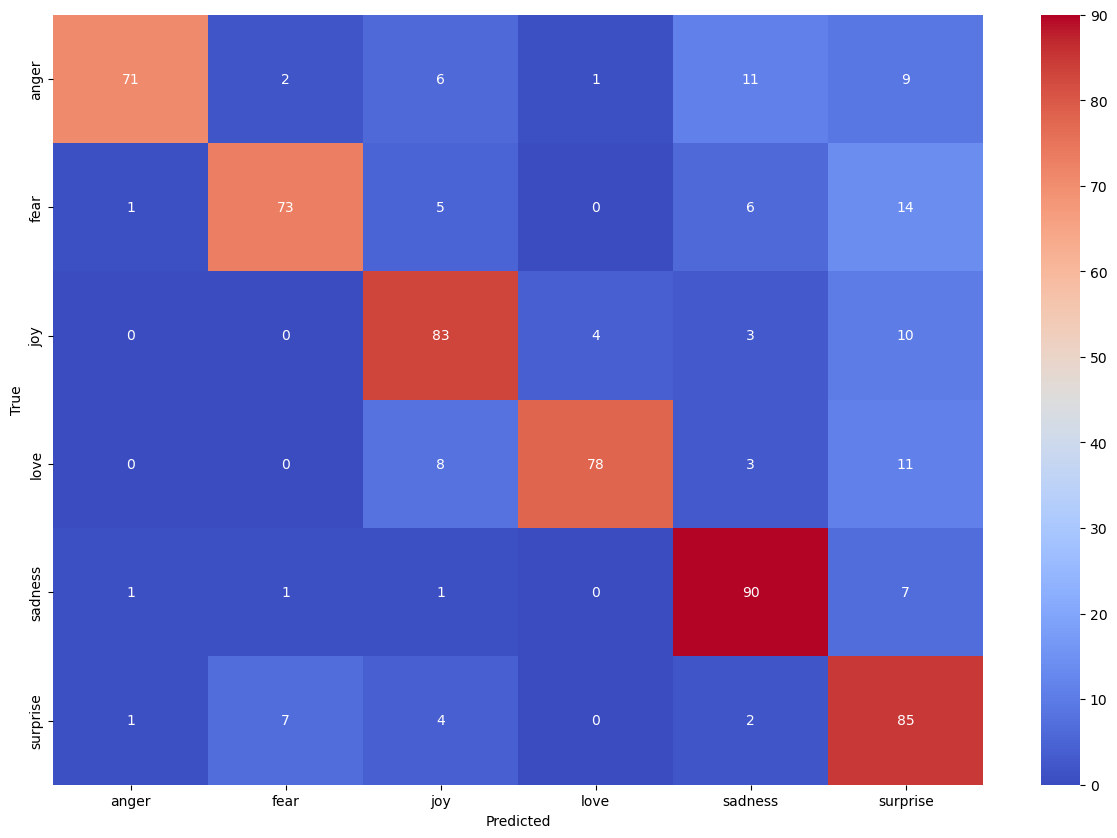

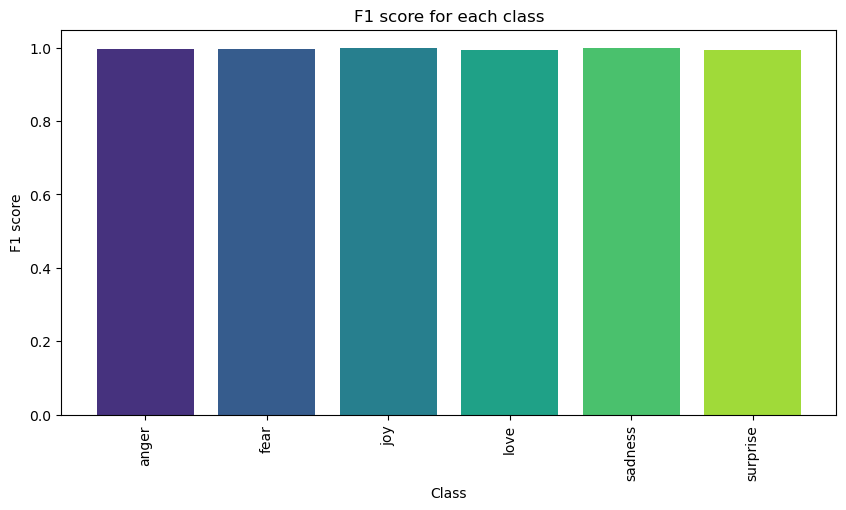

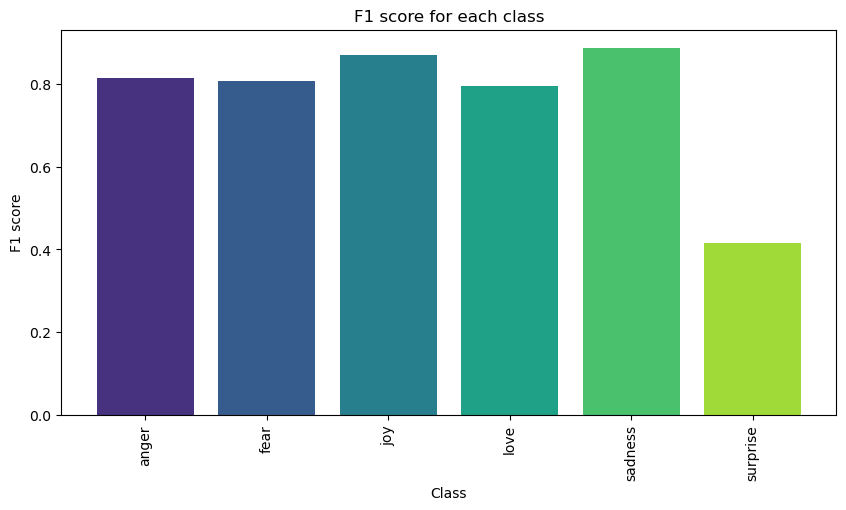

In [8]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer()),
    ('select', SelectKBest(mutual_info_classif, k=2000)),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier())
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

### Trying best so far on raw data to check for cleaning usefulness

In [10]:
# load raw dataset
raw_train_df, raw_val_df, raw_test_df = load_dataset(DatasetEnum.TwitterData, k_hot_encode=True)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                1.00                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                1.00                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

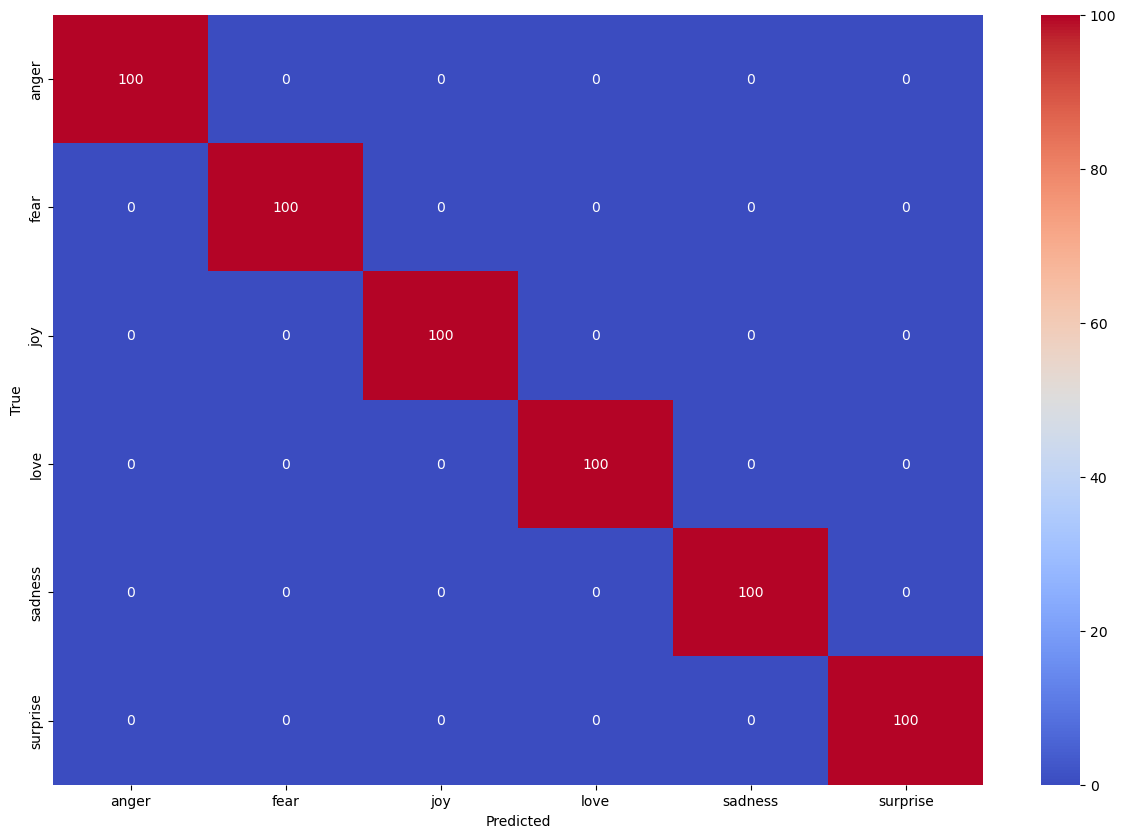

Val confusion matrix


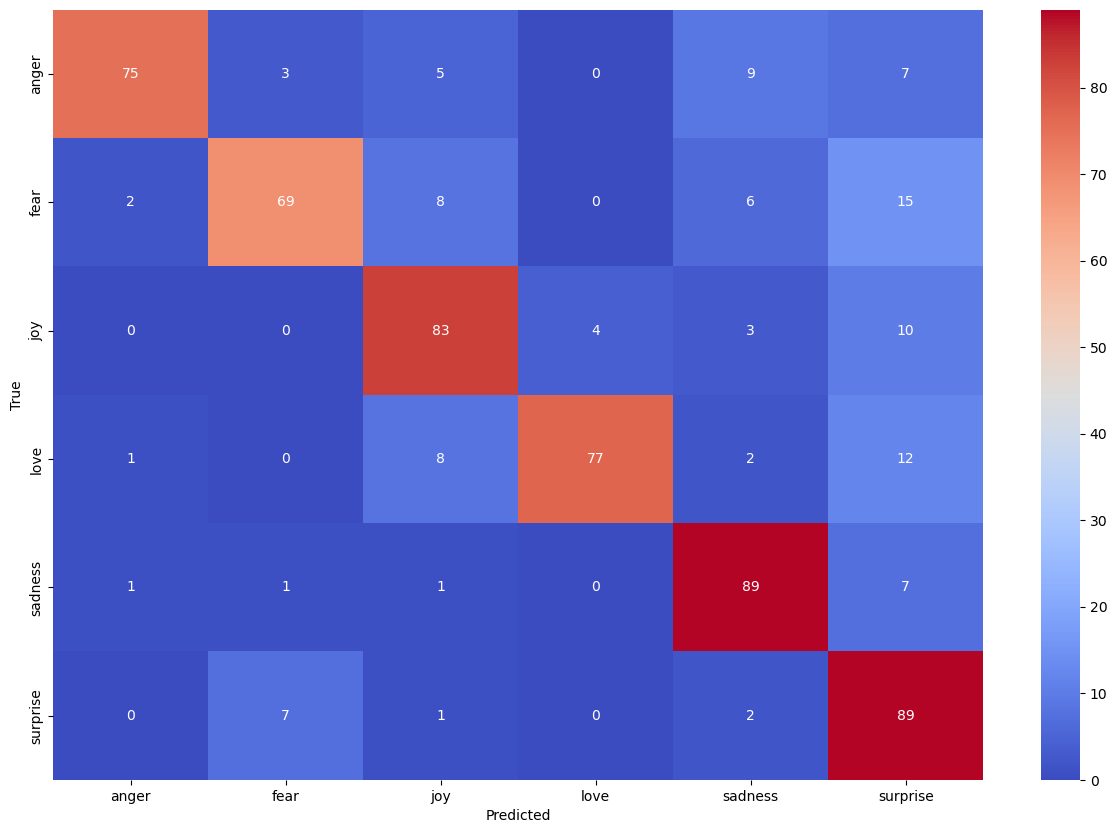

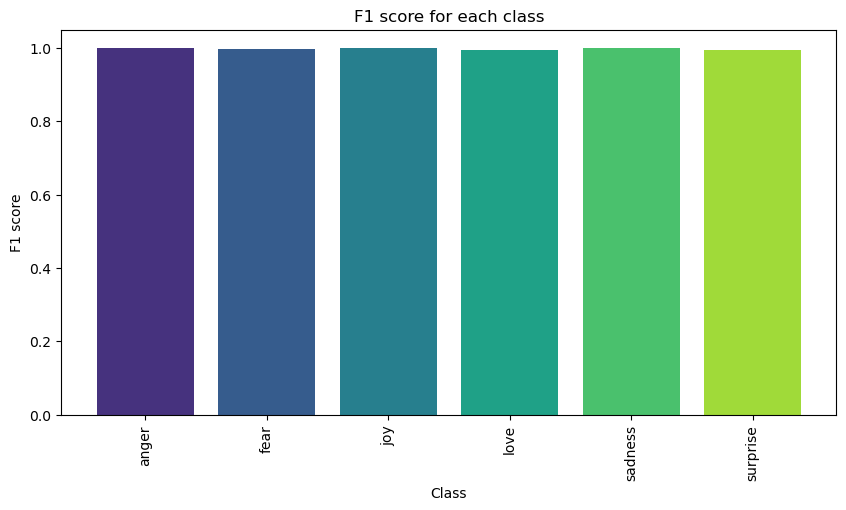

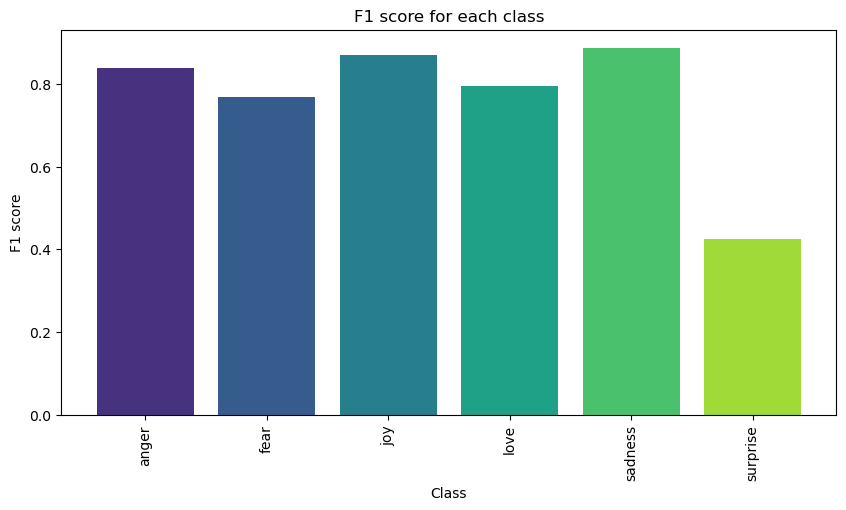

In [11]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(random_state=777))
]))

OVA_clf_analysis(raw_train_df, raw_val_df, classifier, TEXT_COLUMN, LABELS)

In [12]:
train_df, val_df, test_df = load_dataset(DATASET)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                1.00                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                1.00                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

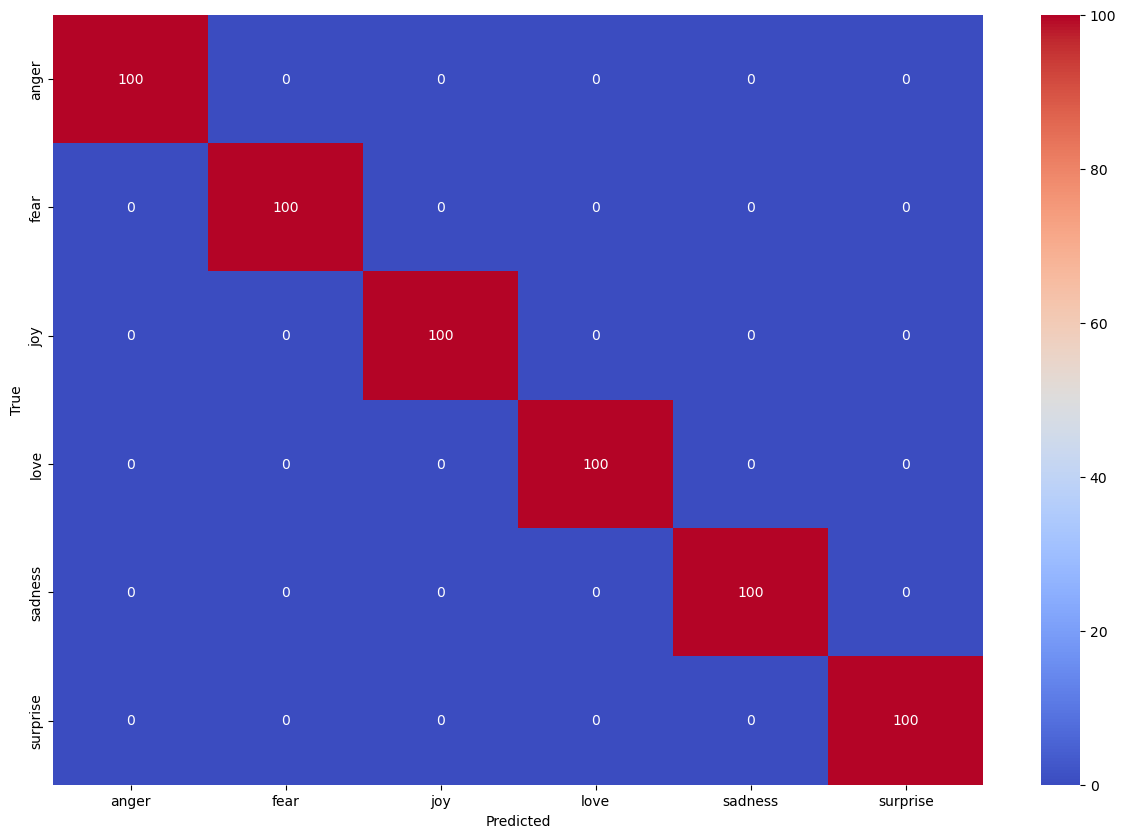

Val confusion matrix


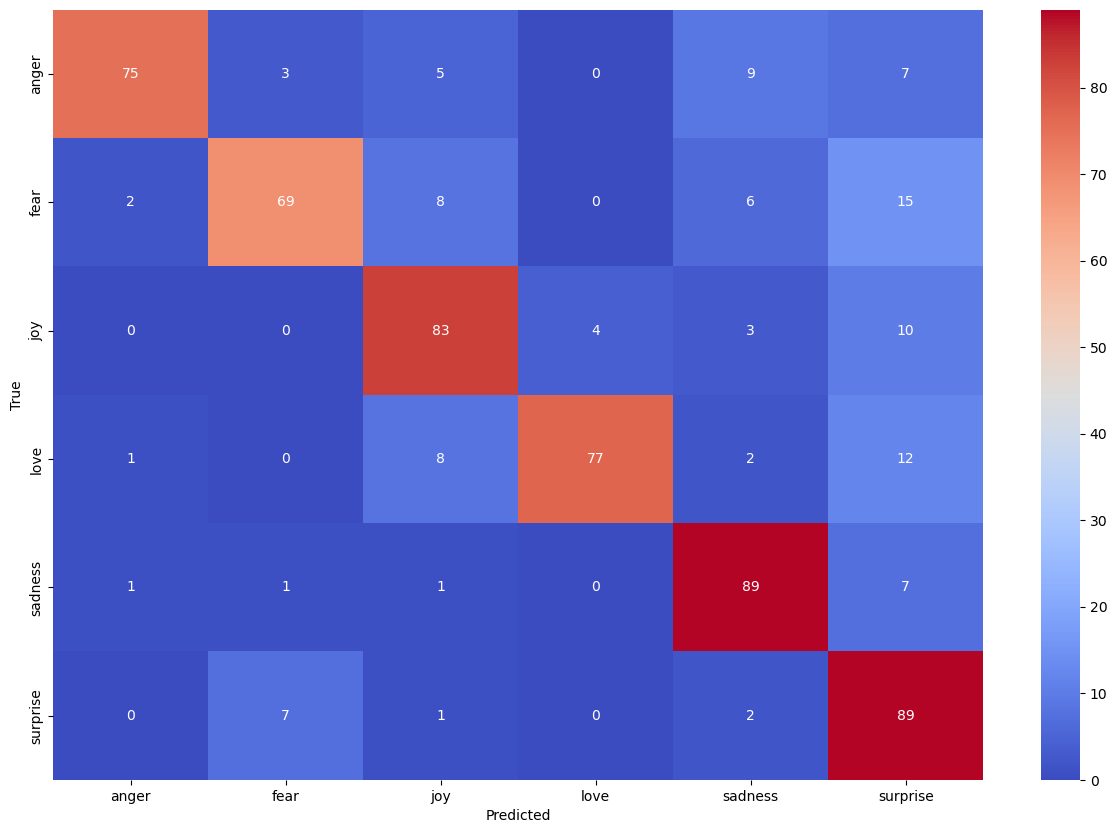

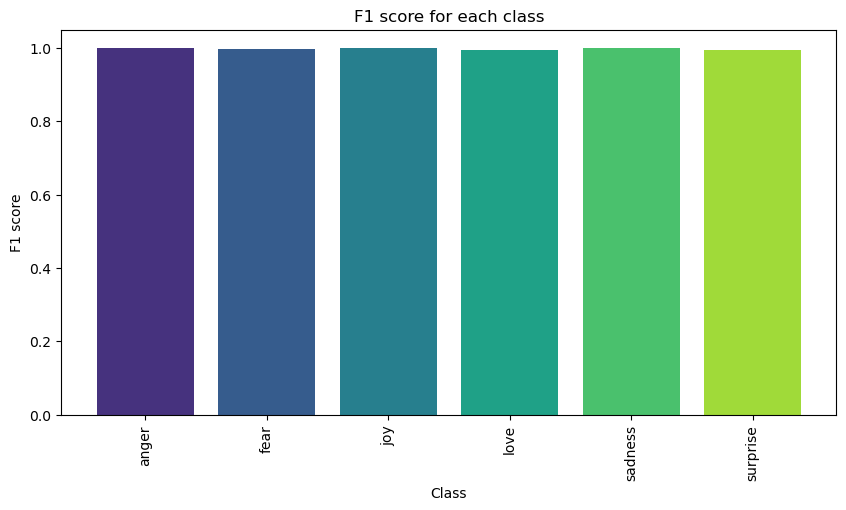

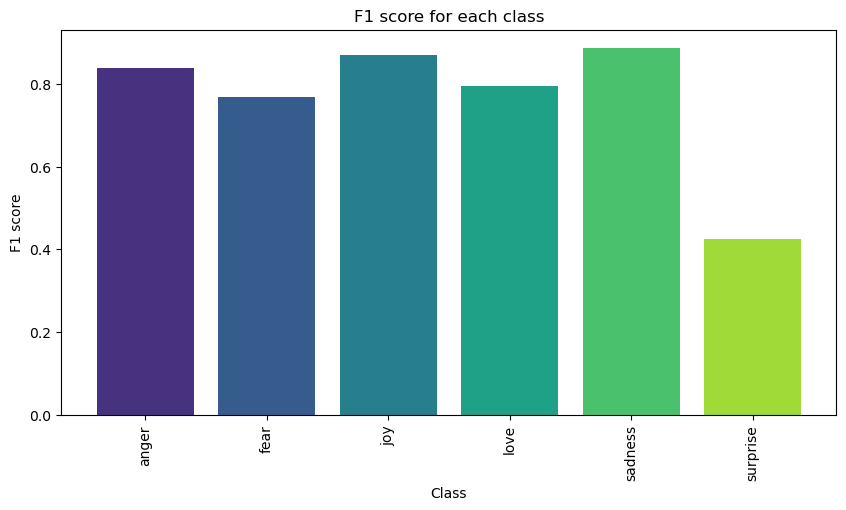

In [13]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(random_state=777))
]))

OVA_clf_analysis(raw_train_df, raw_val_df, classifier, TEXT_COLUMN, LABELS)

No relevant changes in original performance

### Check for difference in performance wrt non OneVsRest

In [14]:
train_df, val_df, test_df = load_dataset(DatasetEnum.TwitterData, k_hot_encode=True)

In [58]:
def sl_classifier(fit_df, predict_df, classifier, text_col, tr_labels):
    classifier.fit(fit_df[text_col], tr_labels)
    # add column to predictions
    predictions_test = np.array(classifier.predict(predict_df[text_col]))
    predictions_train = np.array(classifier.predict(fit_df[text_col]))
    return predictions_train, predictions_test
    
def sl_classifier_analysis(train_df, val_df, classifier, text_col, label_cols):
    # flatten one hot encoded labels with column names
    tr_labels = train_df[label_cols].idxmax(axis=1)
    # train classifier
    predictions_train, predictions_val = sl_classifier(train_df, val_df, classifier, text_col, tr_labels)
    # multilabel binarizer for predictions
    mlb = MultiLabelBinarizer(classes=label_cols)
    predictions_train = mlb.fit_transform(predictions_train.reshape(-1, 1))
    predictions_val = mlb.fit_transform(predictions_val.reshape(-1, 1))
    # convert to dataframe
    predictions_train = pd.DataFrame(predictions_train, columns=label_cols)
    predictions_val = pd.DataFrame(predictions_val, columns=label_cols)
    # calculate metrics
    print("Train metrics")
    scores_dict = get_scores_dict(predictions_train, train_df, label_cols)
    custom_classification_report(scores_dict, label_cols)
    print("Val metrics")
    scores_dict = get_scores_dict(predictions_val, val_df, label_cols)
    custom_classification_report(scores_dict, label_cols)
    # plot confusion matrix
    print("Train confusion matrix")
    plot_multilabel_confusion_heatmap(train_df[label_cols].to_numpy(), predictions_train.values, label_cols, label_cols, normalize=True)
    print("Val confusion matrix")
    plot_multilabel_confusion_heatmap(val_df[label_cols].to_numpy(), predictions_val.values, label_cols, label_cols, normalize=True)
    # bar plot over classes
    plot_score_barplot(train_df[label_cols], predictions_train, label_cols)
    plot_score_barplot(val_df[label_cols], predictions_val, label_cols)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                1.00                0.99                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            1.00                0.99                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

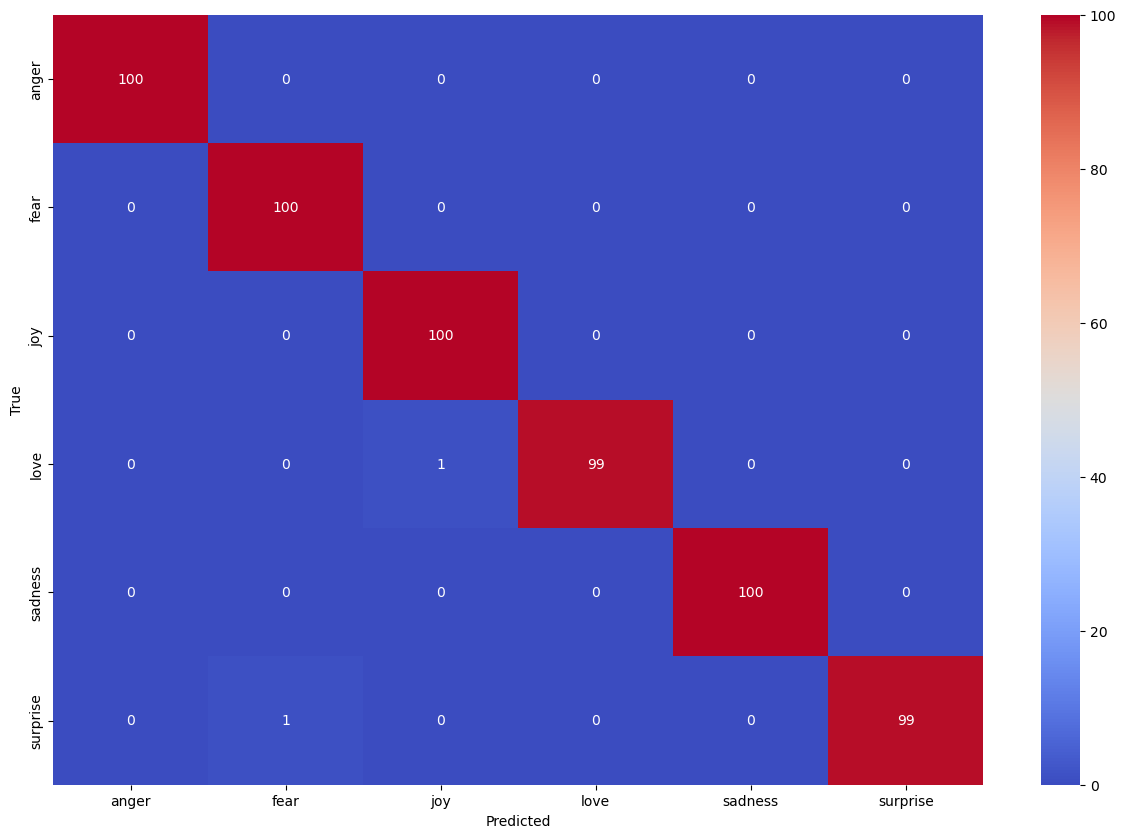

Val confusion matrix


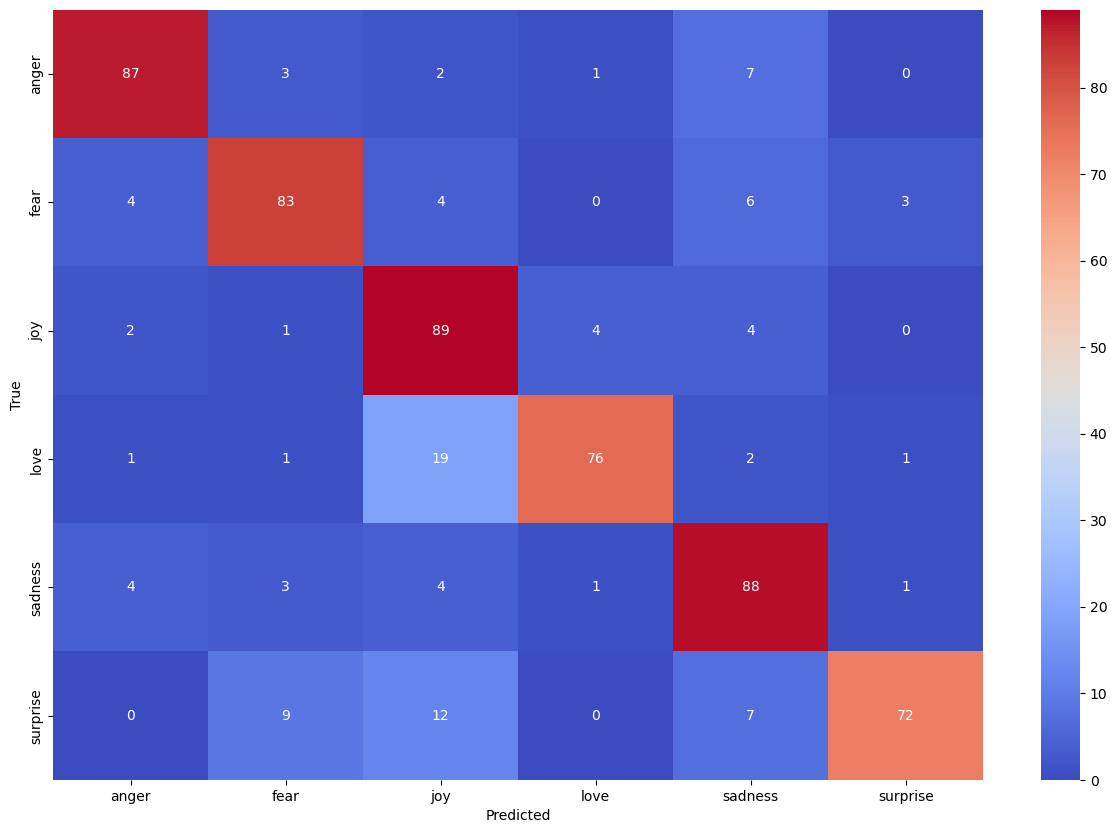

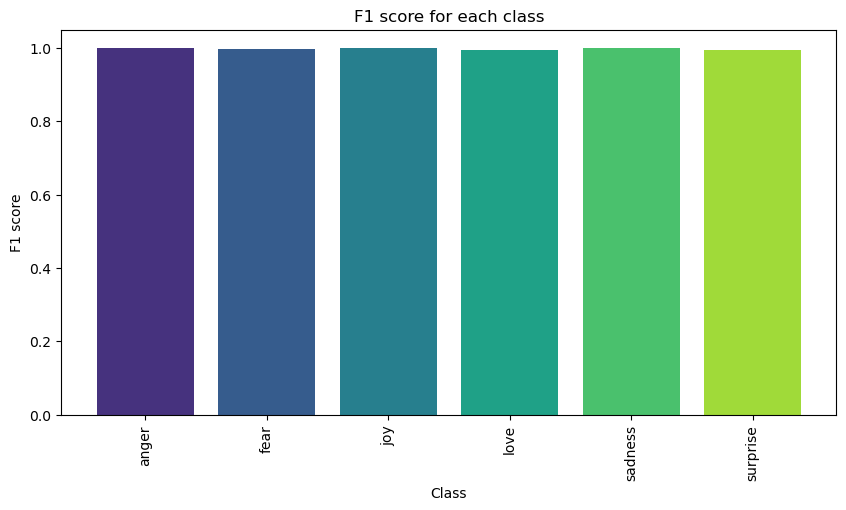

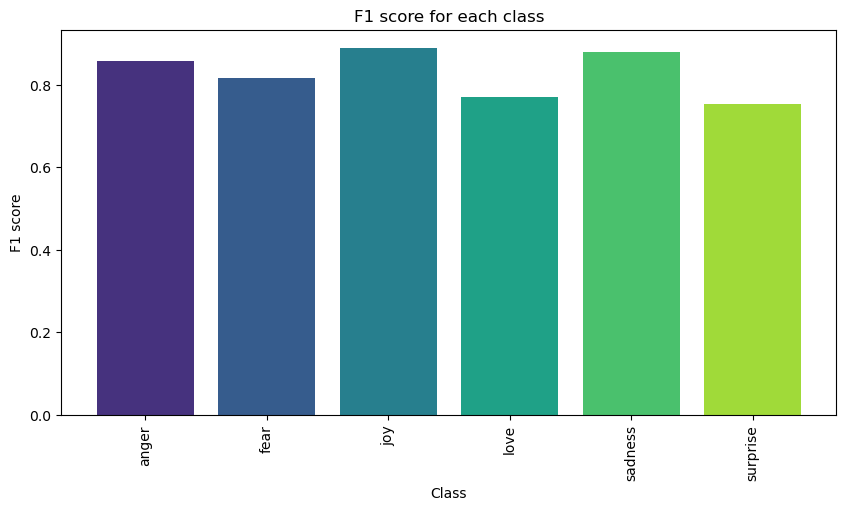

In [16]:
# training one versus rest classifier
classifier = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(random_state=777))
])

sl_classifier_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

One vs rest yealds worse performances

# TFIDF Random forest

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                1.00                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            1.00                0.99                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

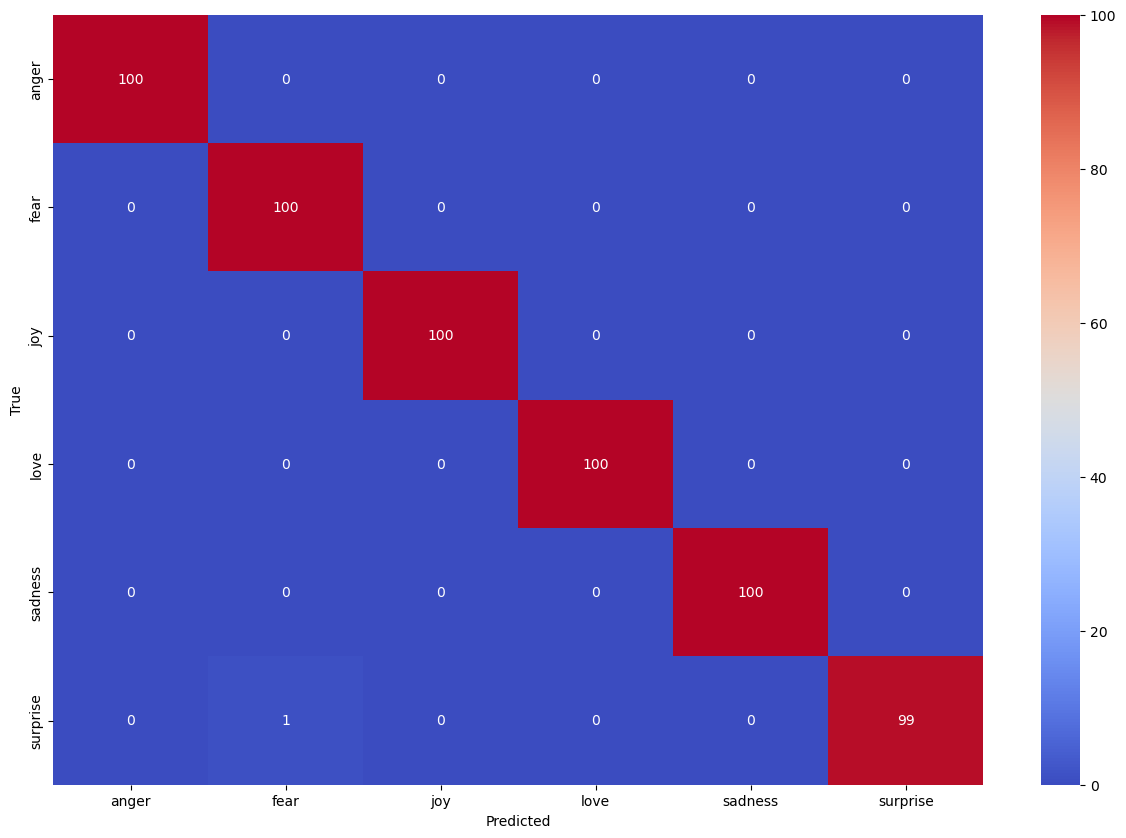

Val confusion matrix


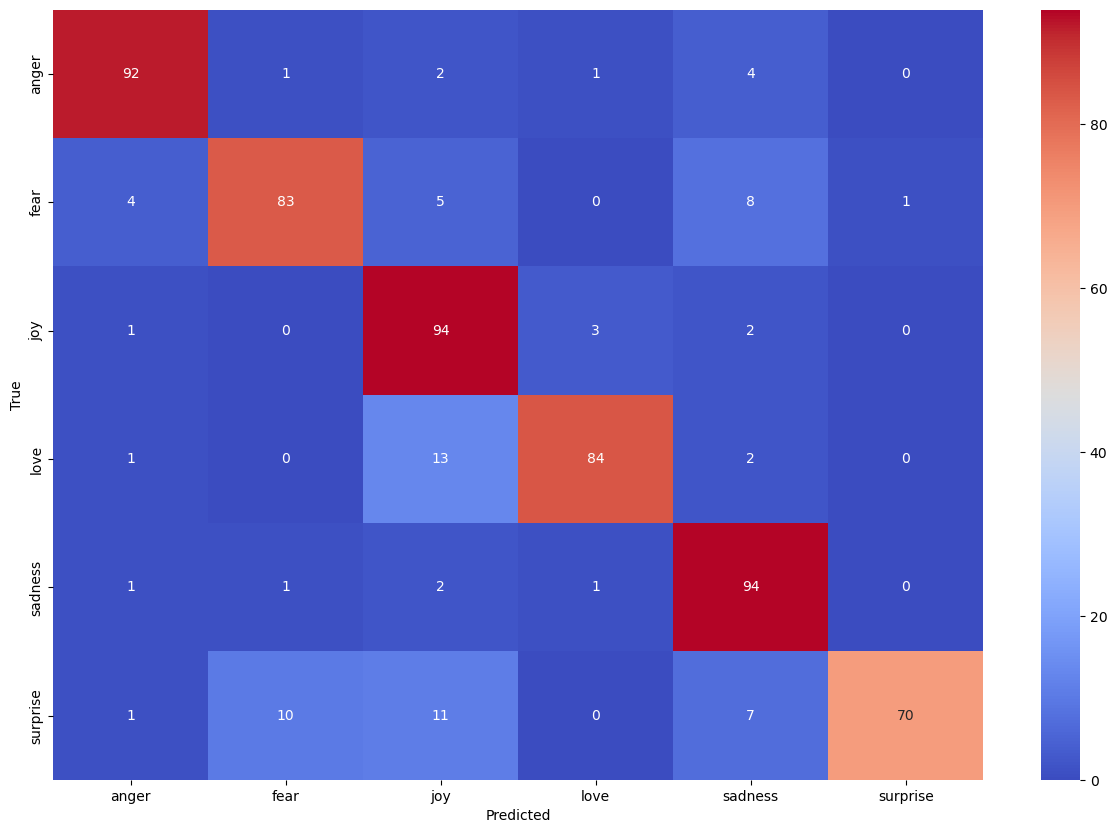

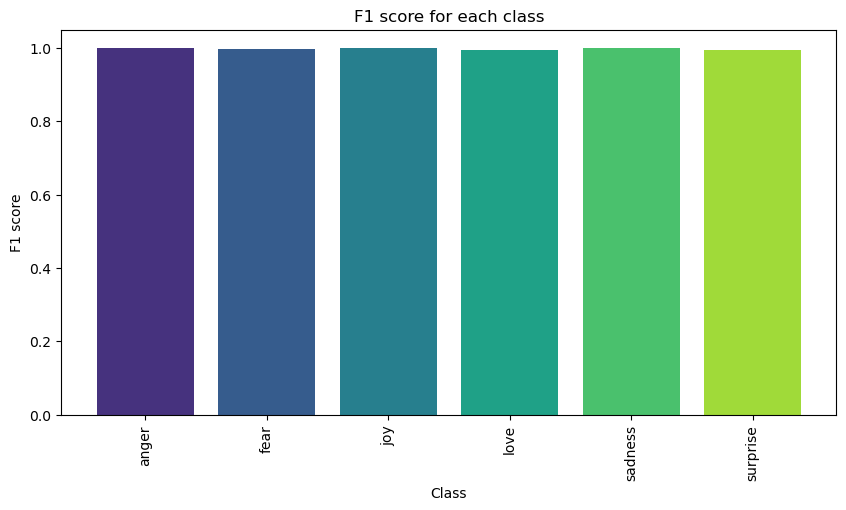

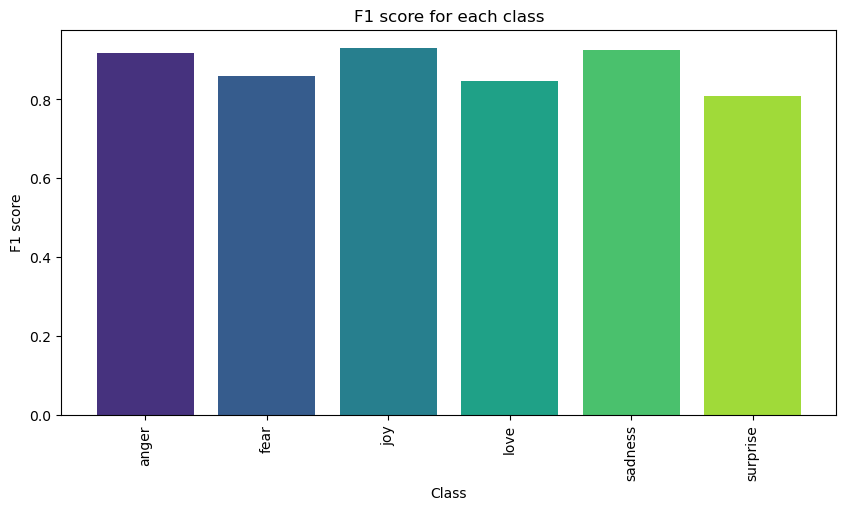

In [17]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                0.99                2159
fear                                0.99                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                1.00                0.99                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            1.00                0.99                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

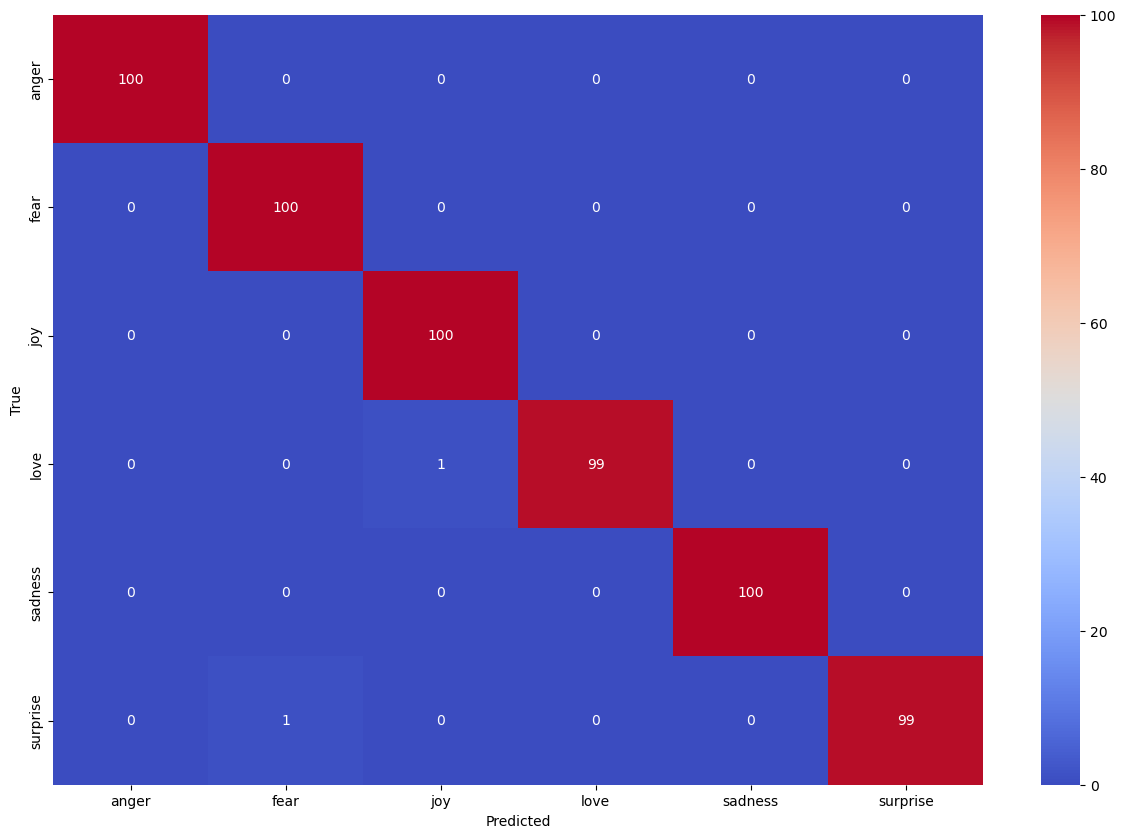

Val confusion matrix


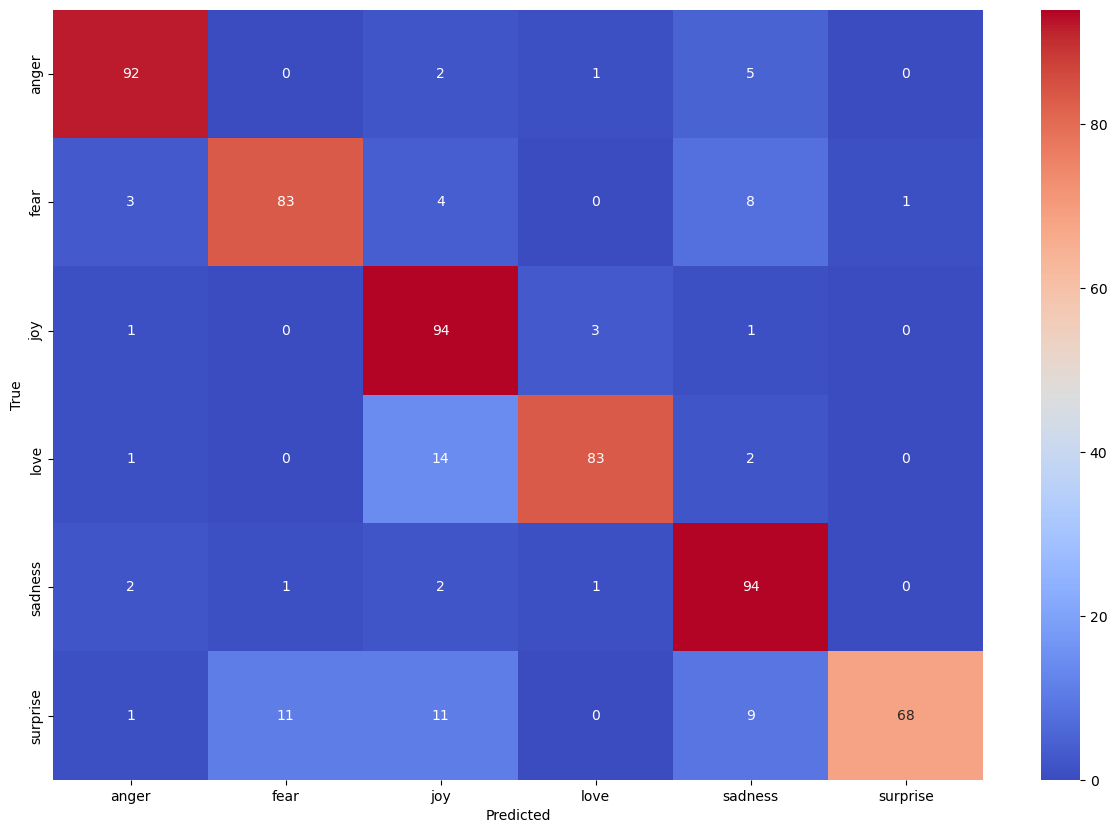

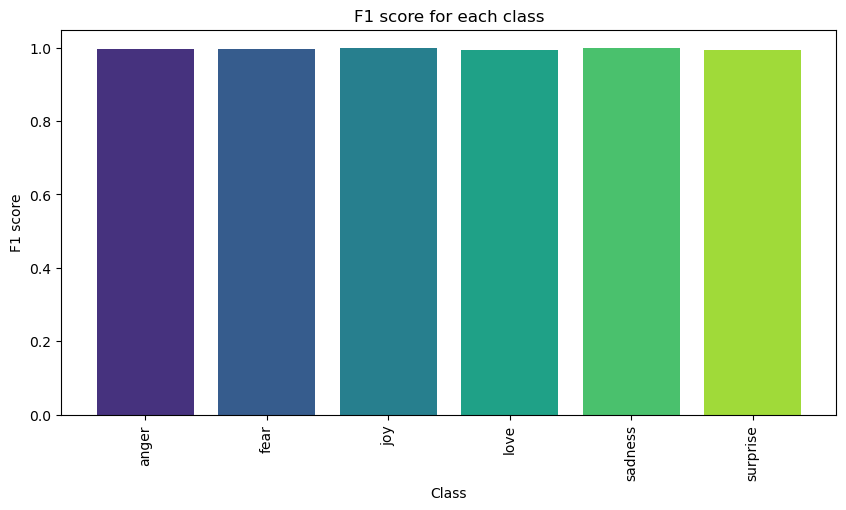

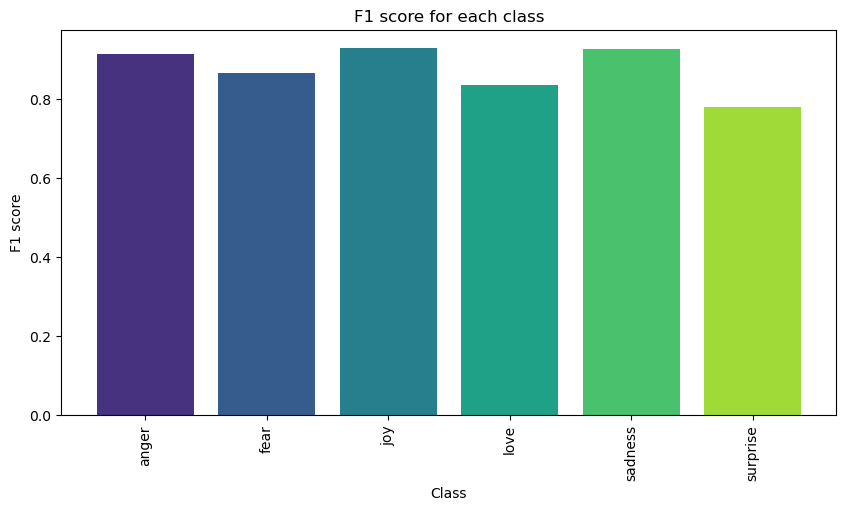

In [18]:
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10, random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

faster and with same results

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                0.99                2159
fear                                0.99                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                1.00                0.99                0.99                0.98                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            1.00                0.98                0.99                0.98                 572
Macro avg                           1.00                0.99                1.00                0.99               1

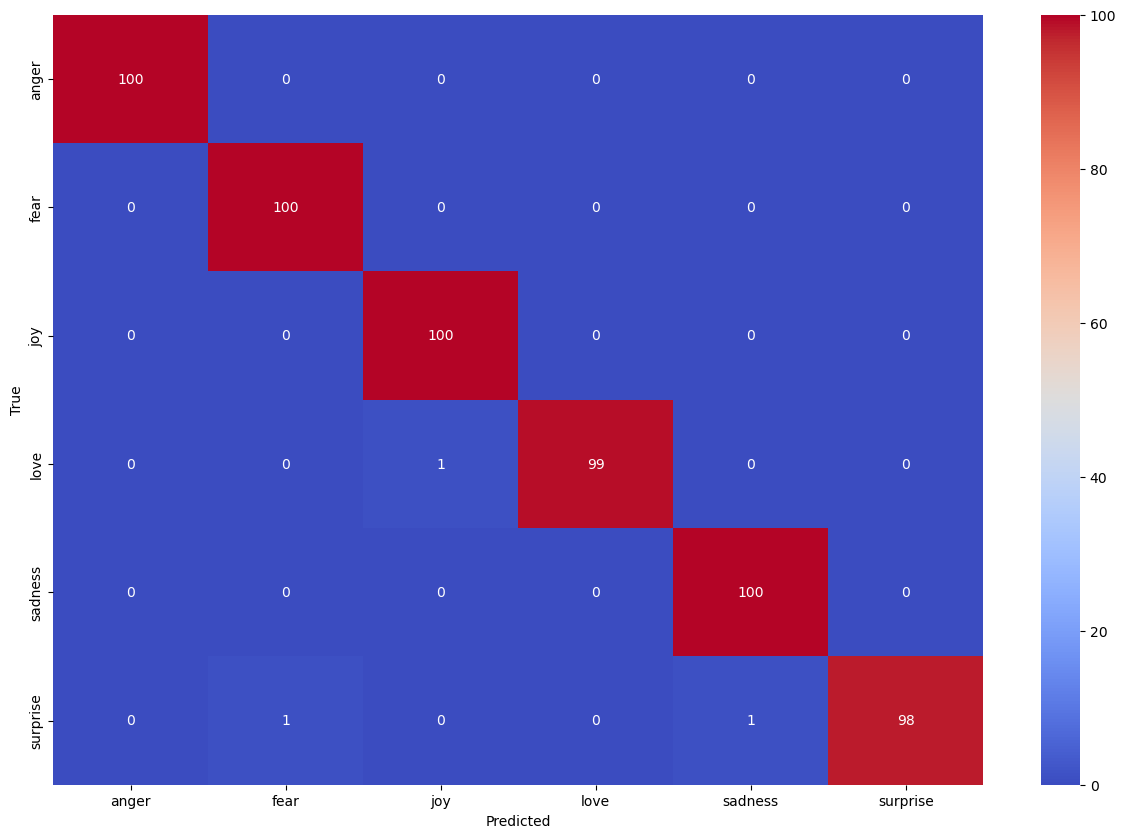

Val confusion matrix


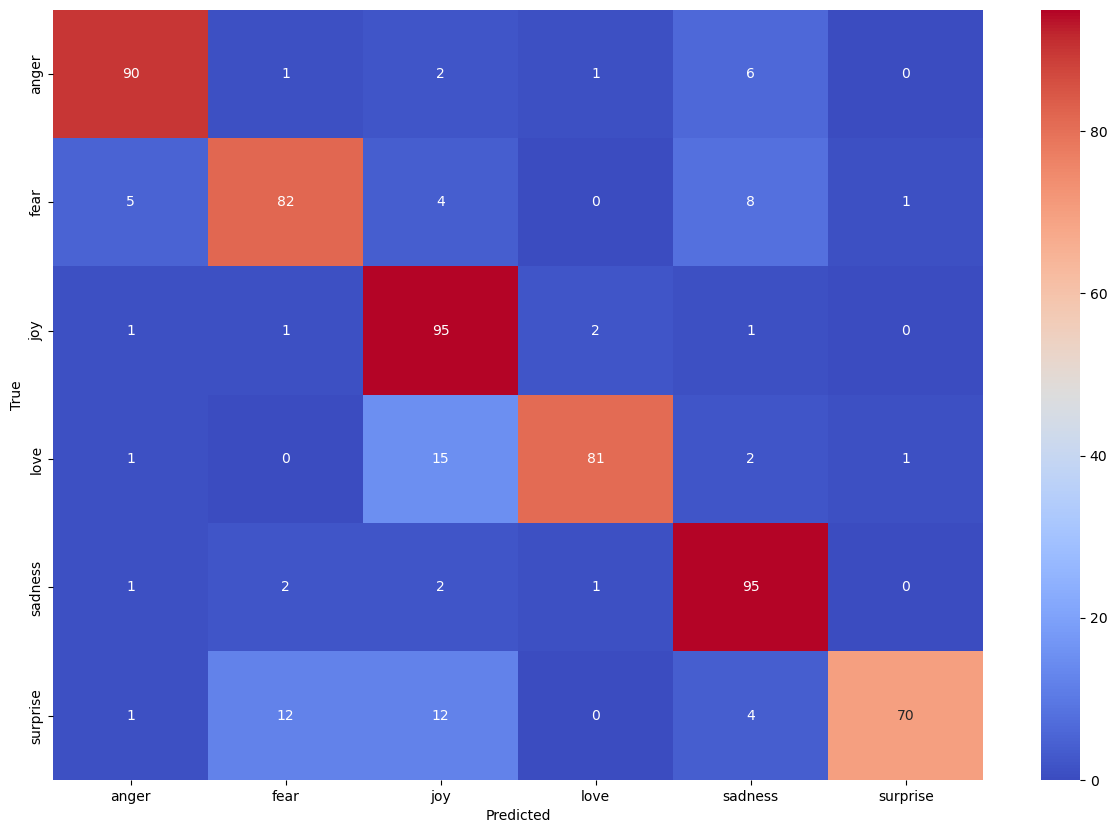

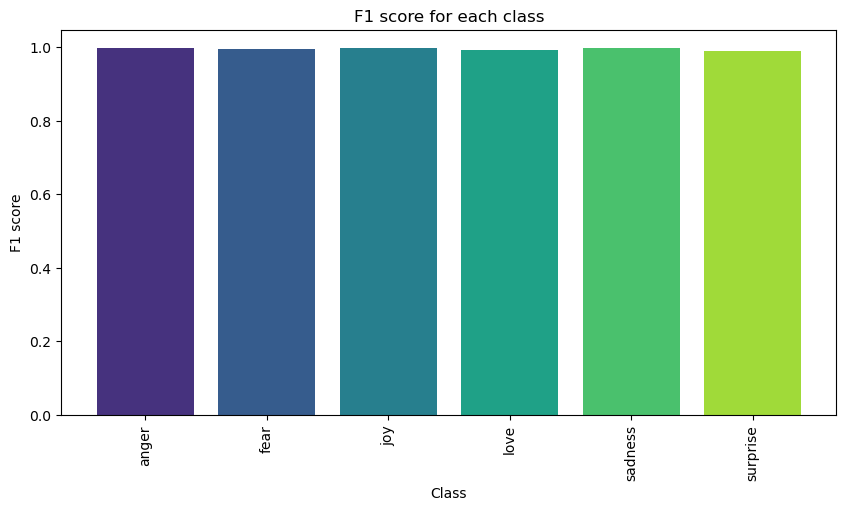

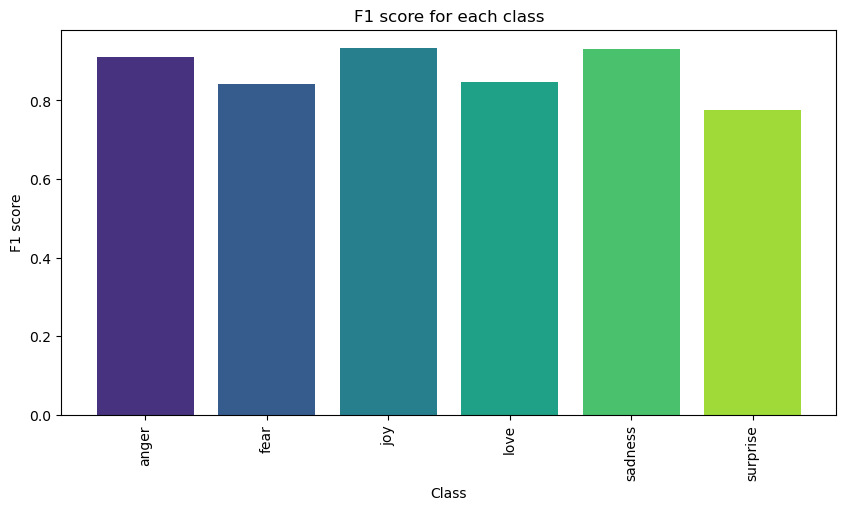

In [19]:
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10, max_features=1000, random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

more features => better results

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                0.99                2159
fear                                0.99                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                1.00                0.99                0.99                0.98                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                0.98                0.99                0.98                 572
Macro avg                           1.00                0.99                1.00                0.99               1

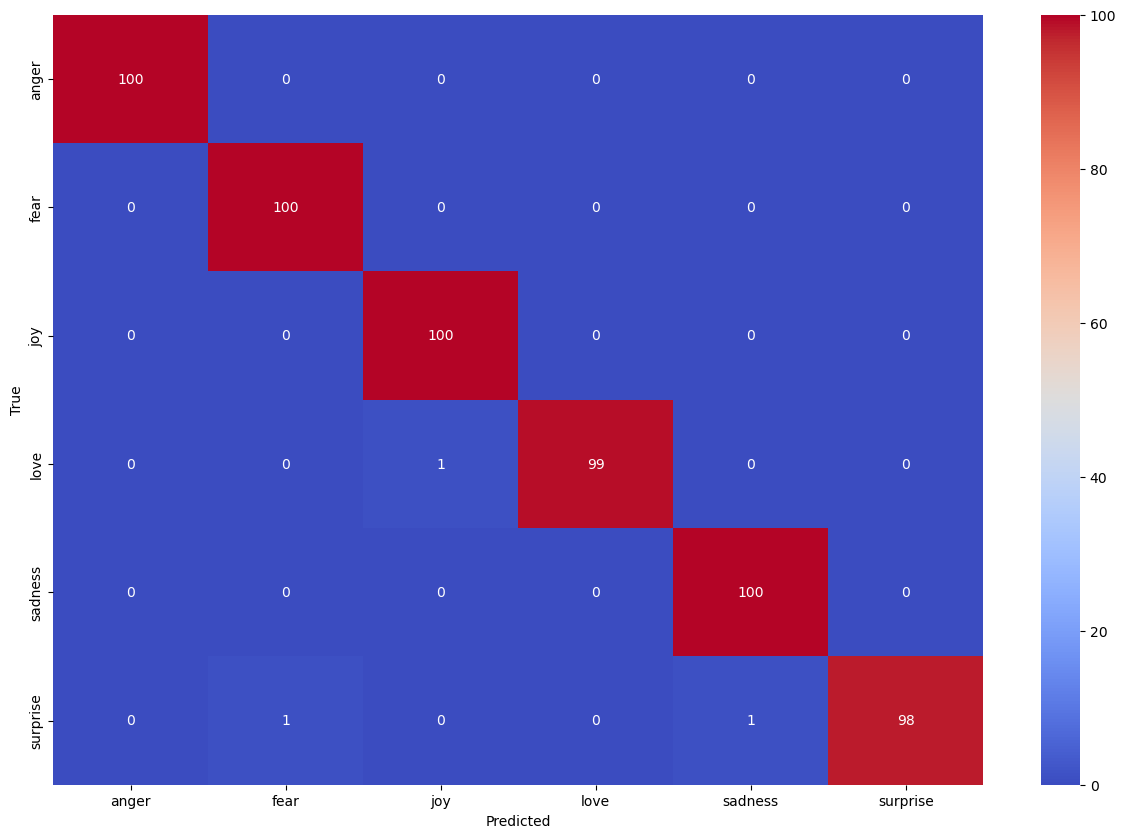

Val confusion matrix


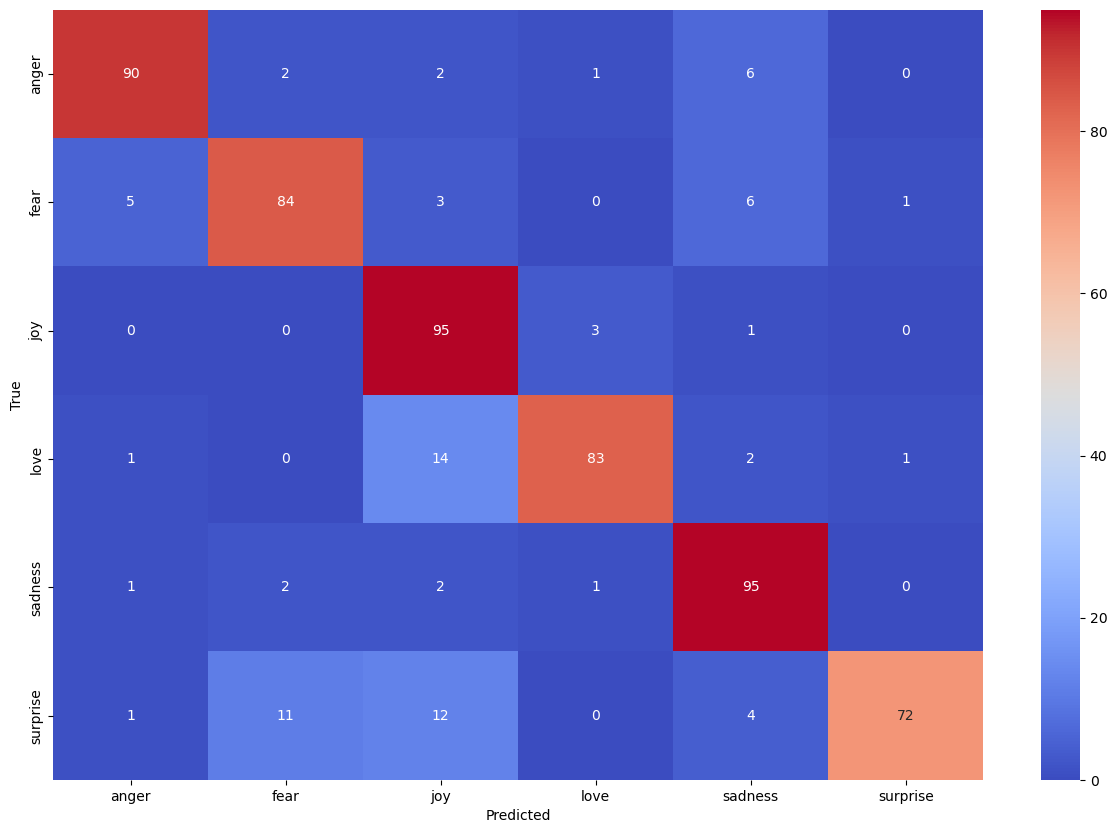

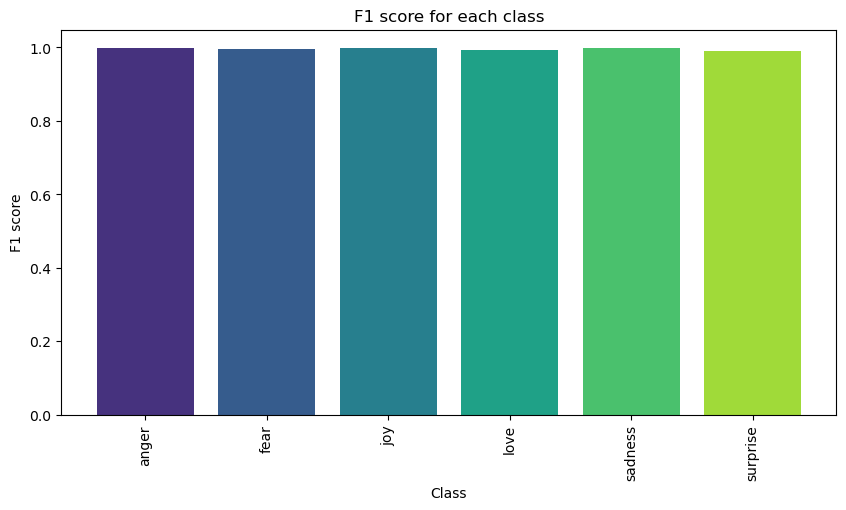

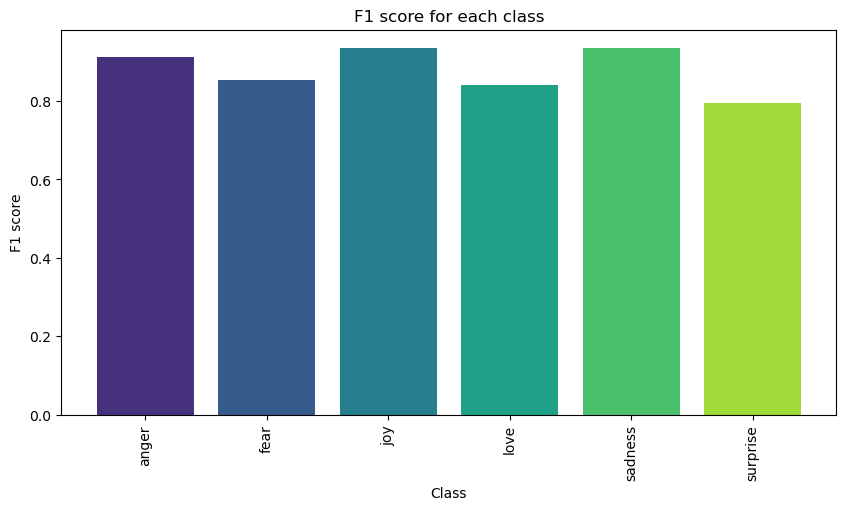

In [20]:
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10, max_features=2000, random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                1.00                0.99                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                0.99                0.99                0.98                 572
Macro avg                           1.00                1.00                1.00                0.99               1

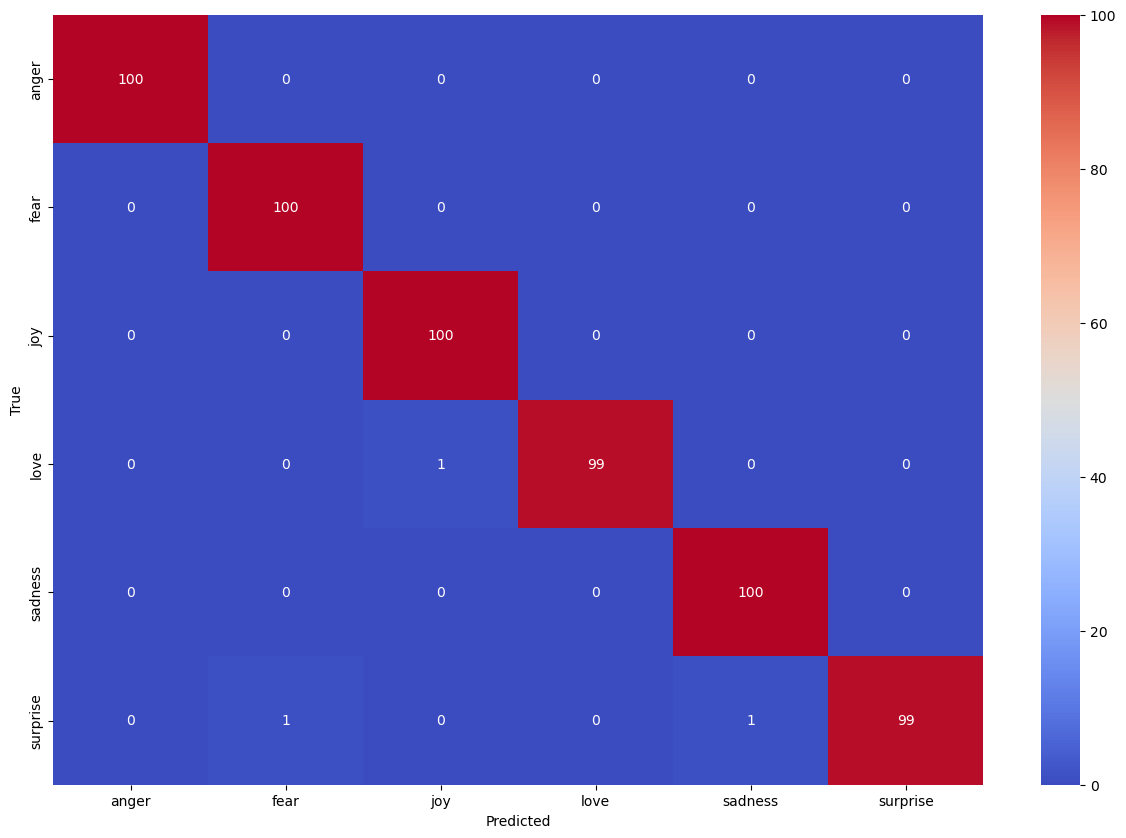

Val confusion matrix


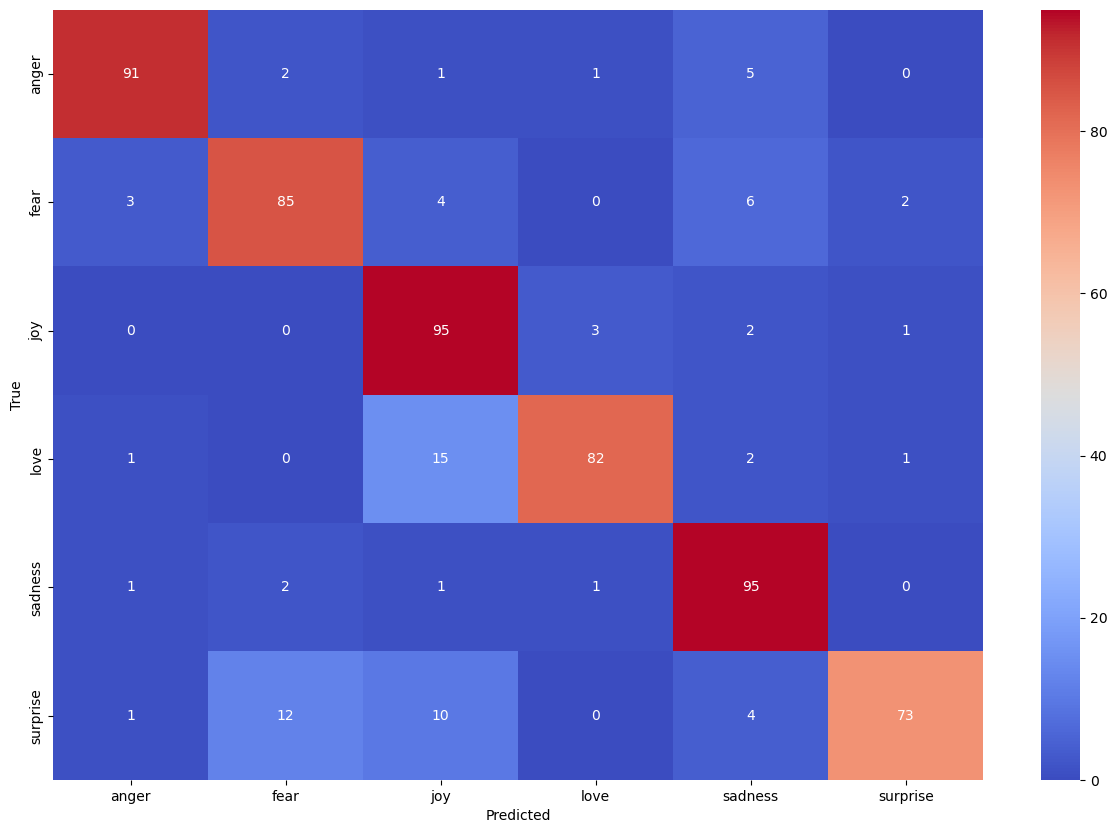

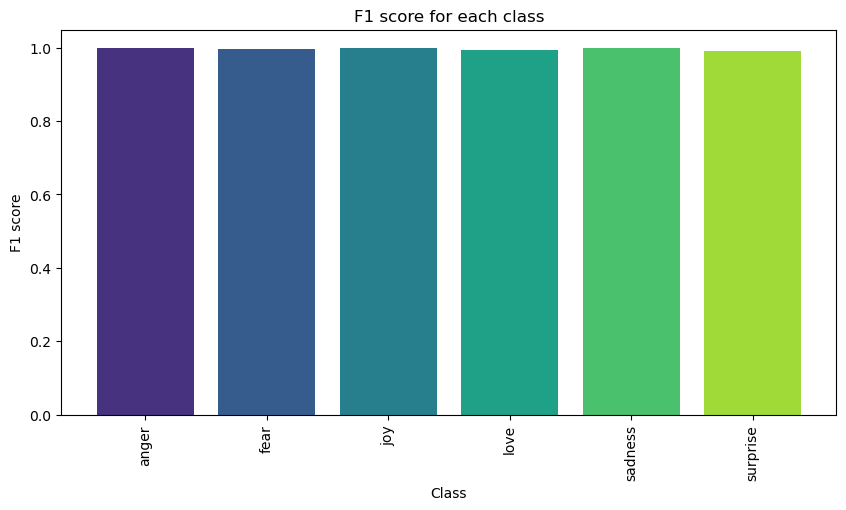

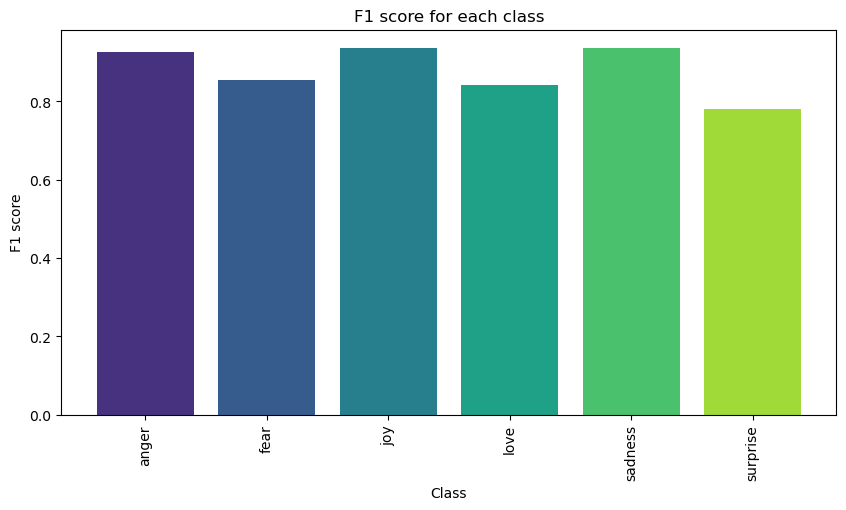

In [21]:
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10, max_features=4000, random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                0.99                1.00                0.99                2159
fear                                0.99                0.99                0.99                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                0.99                0.99                0.98                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                0.98                0.99                0.97                 572
Macro avg                           1.00                0.99                0.99                0.99               1

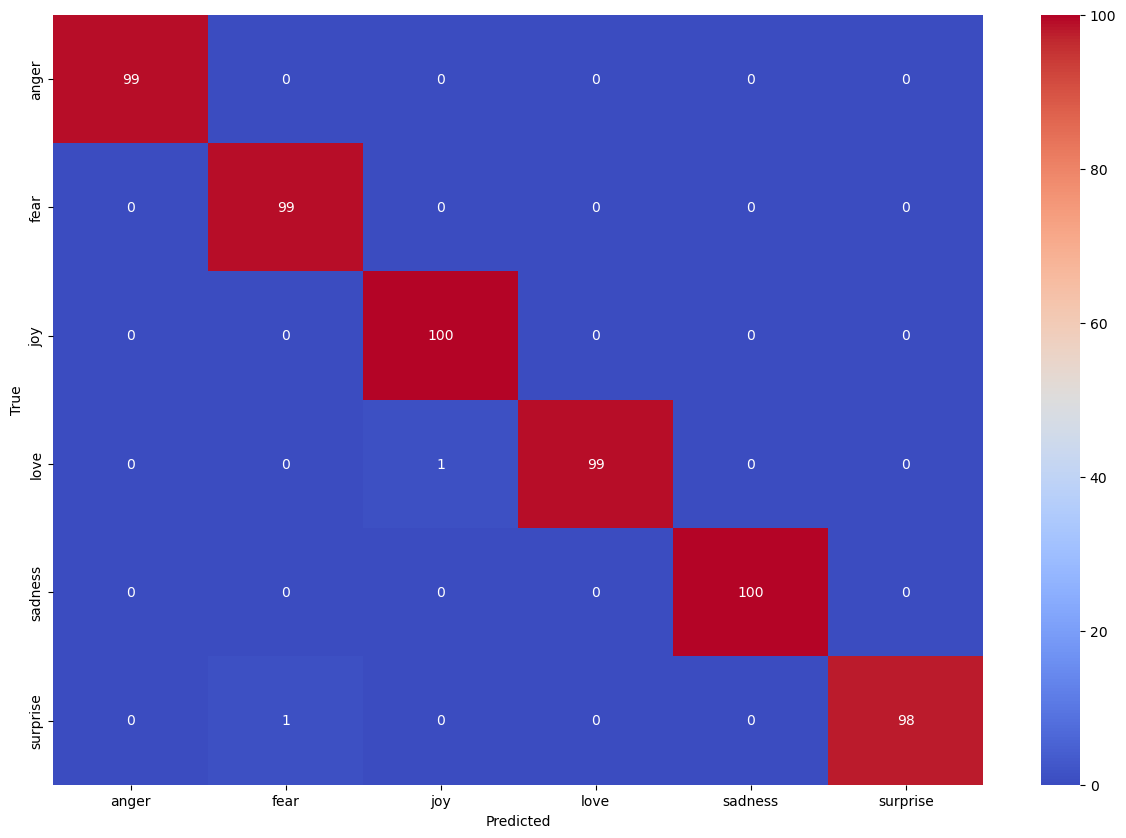

Val confusion matrix


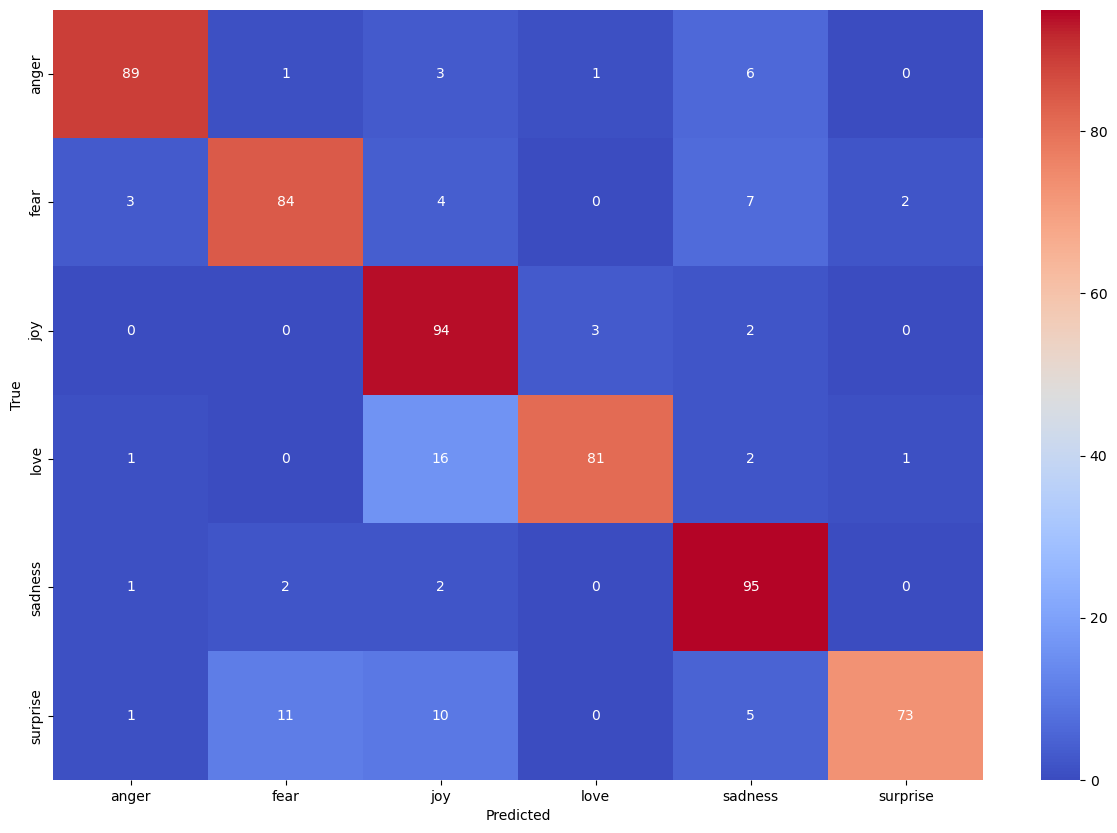

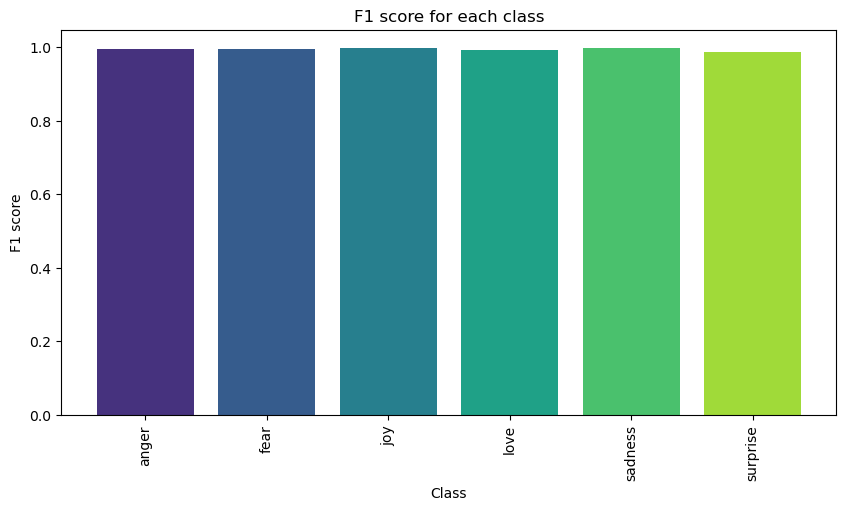

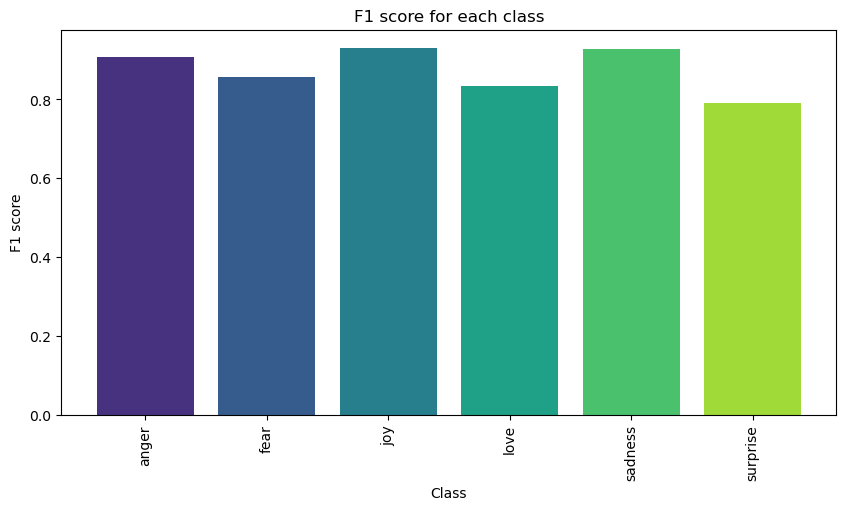

In [22]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=2)),
    ('select', SelectKBest(mutual_info_classif, k=2000)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10, random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                0.99                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                1.00                0.99                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                0.99                0.99                0.99                 572
Macro avg                           1.00                0.99                1.00                0.99               1

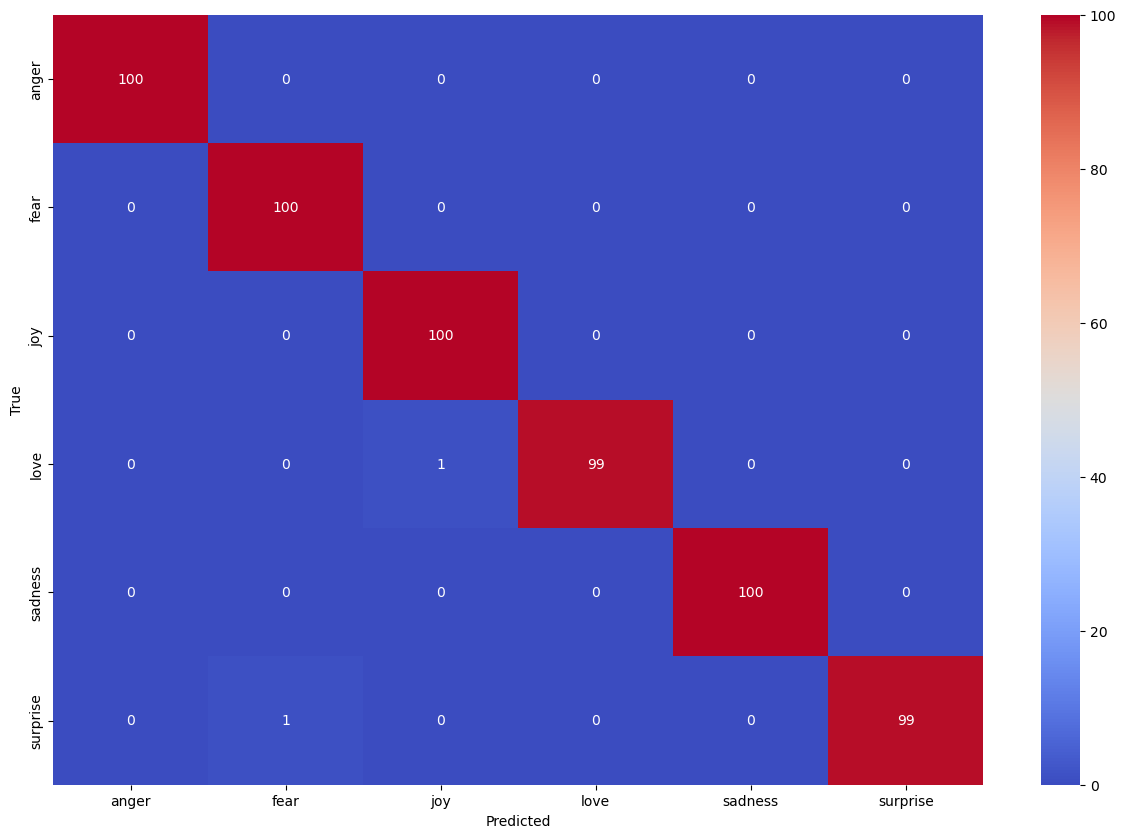

Val confusion matrix


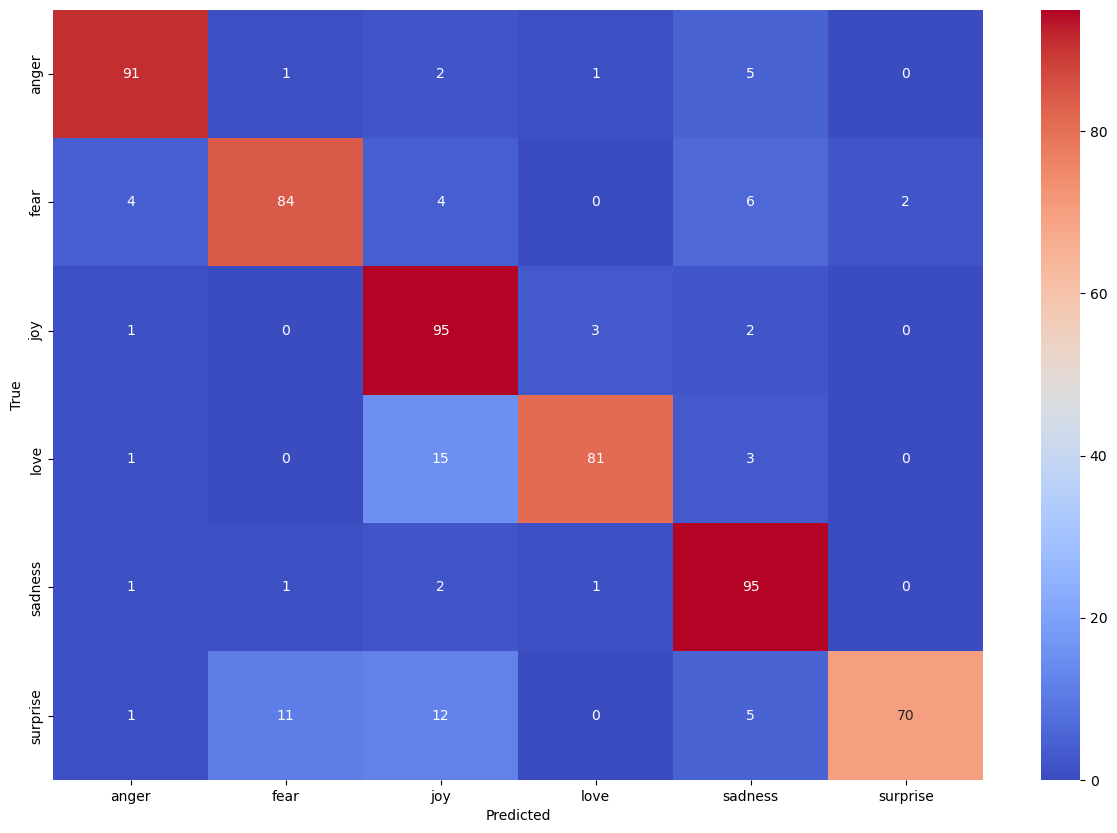

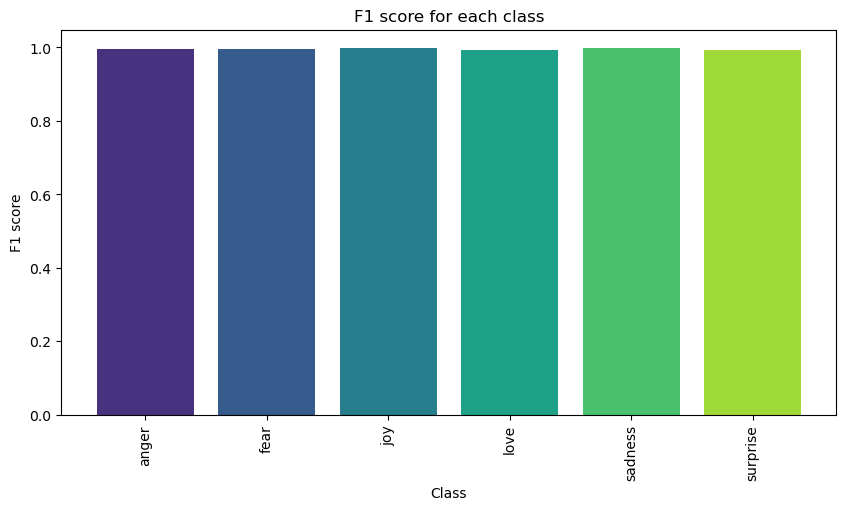

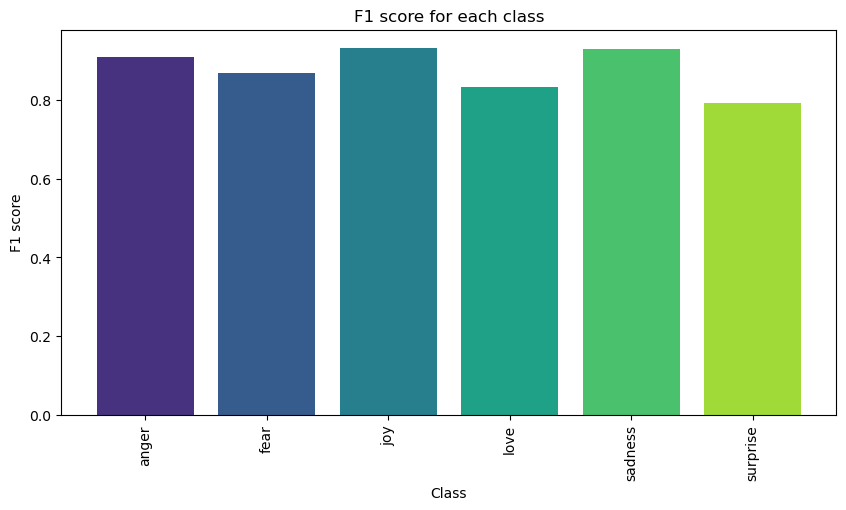

In [23]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=2)),
    ('select', SelectKBest(mutual_info_classif, k=5000)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=10, random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.99                1.00                1.00                0.99                2159
fear                                1.00                0.99                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                0.99                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            0.99                0.99                0.99                0.98                 572
Macro avg                           1.00                1.00                1.00                0.99               1

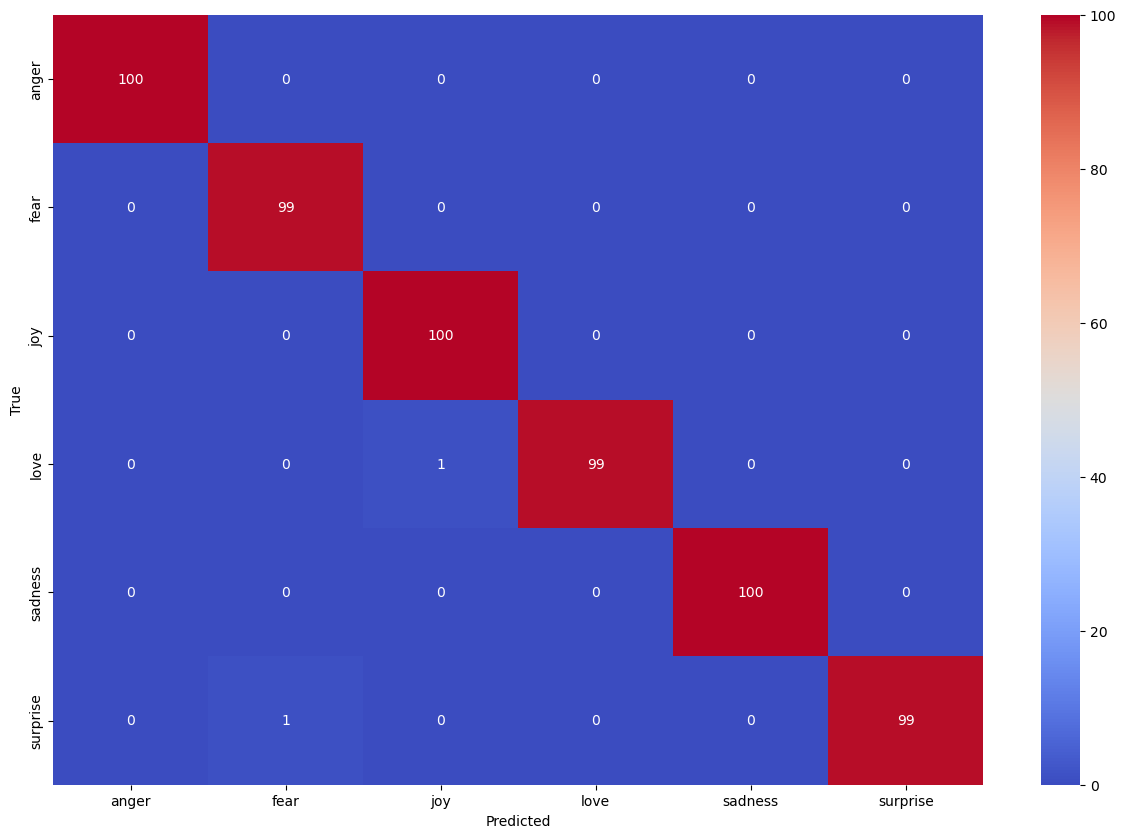

Val confusion matrix


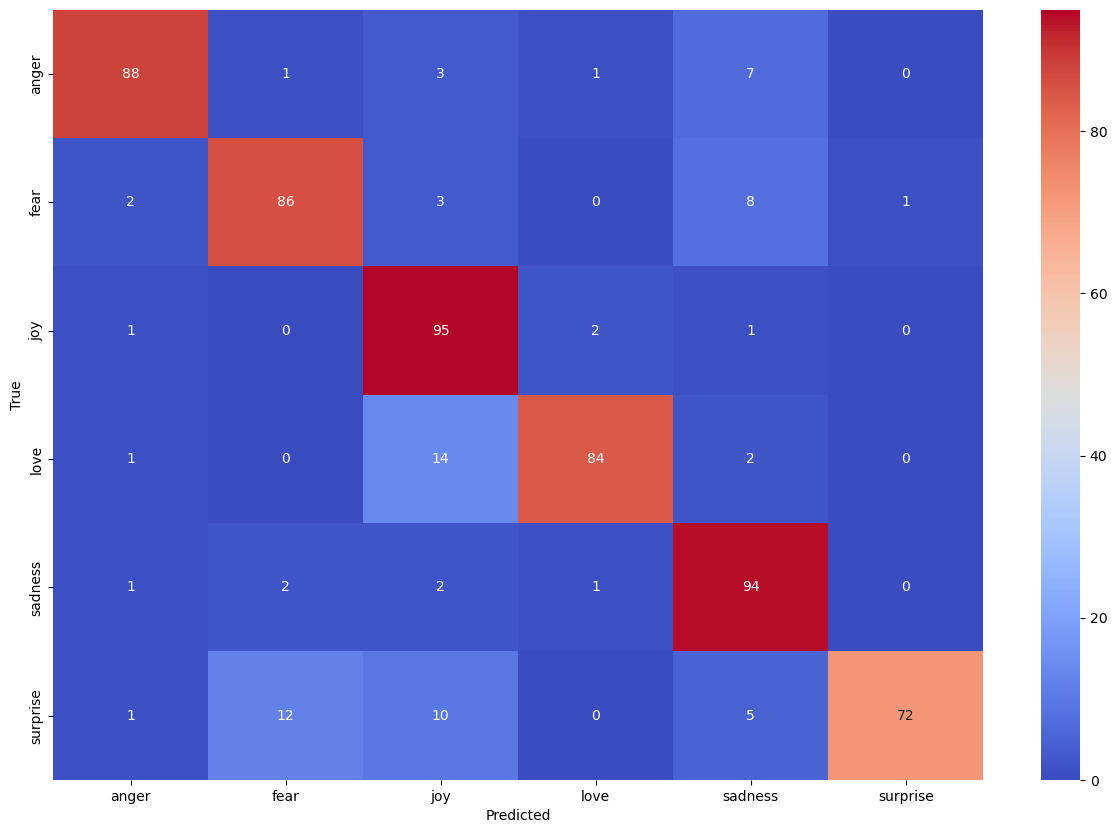

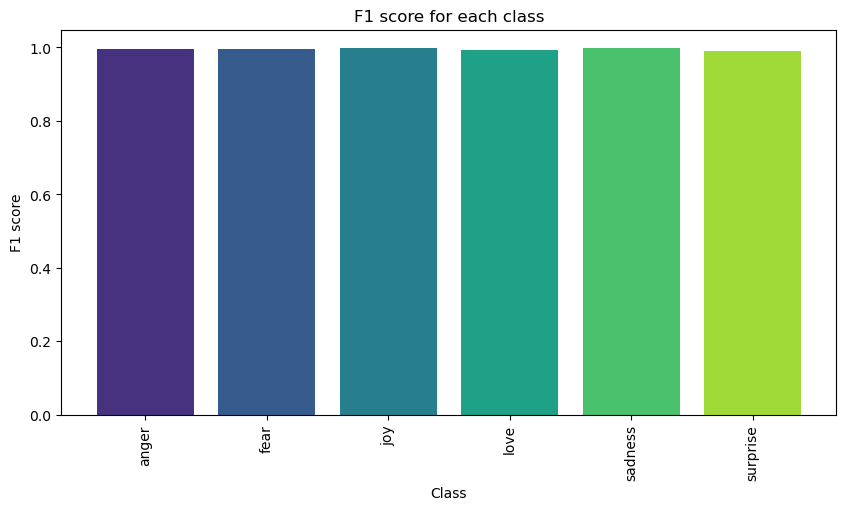

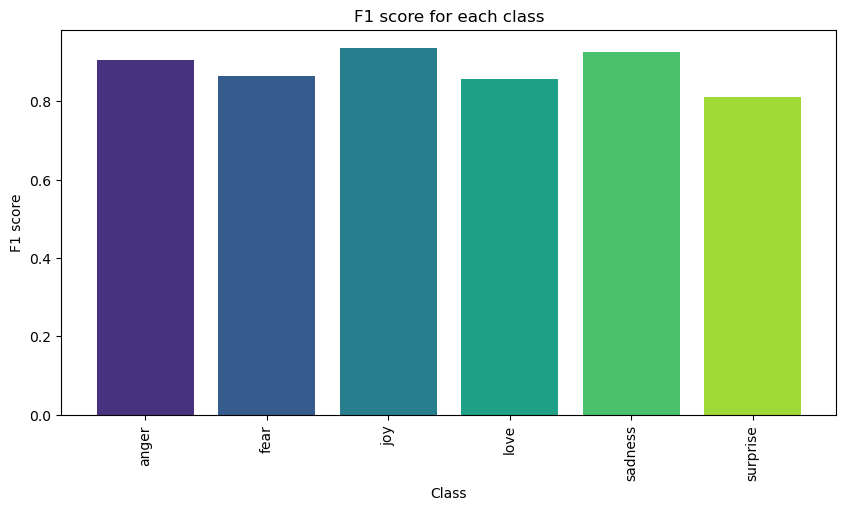

In [24]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer()),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_jobs=-1, min_samples_split=5, random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

## Compare best without one vs rest

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                1.00                0.99                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            1.00                0.99                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

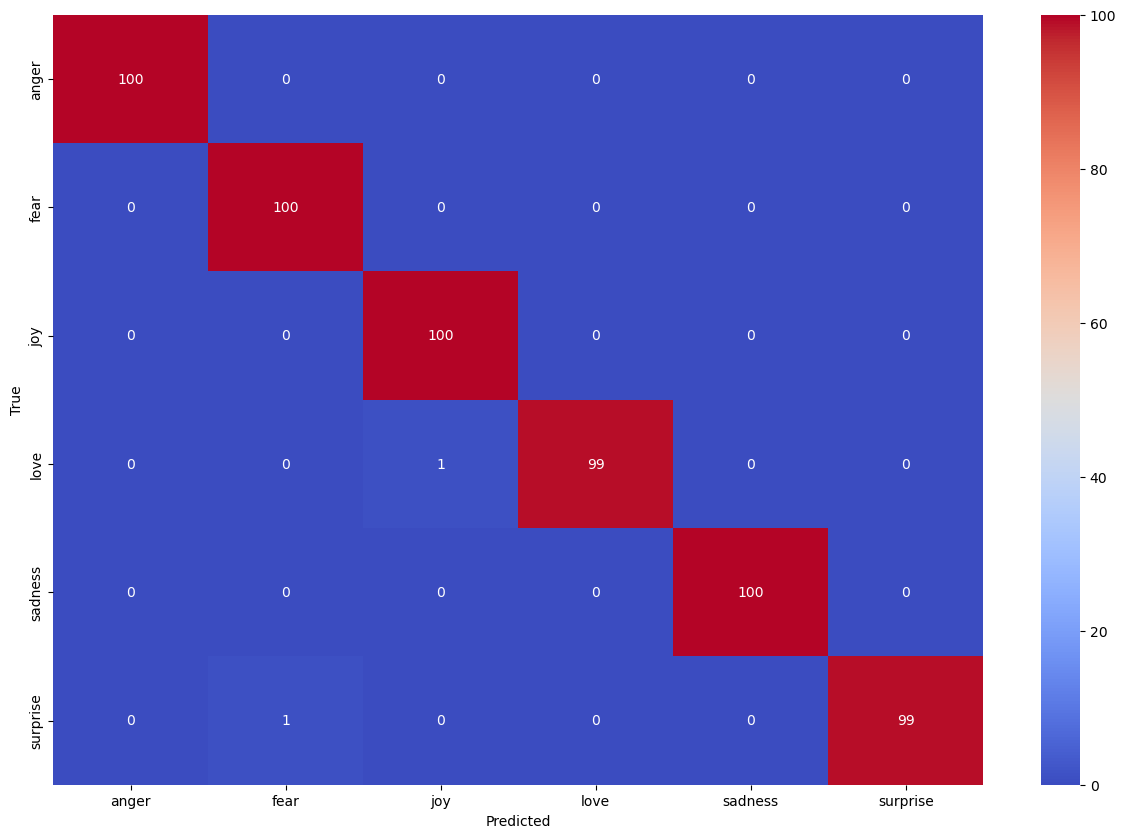

Val confusion matrix


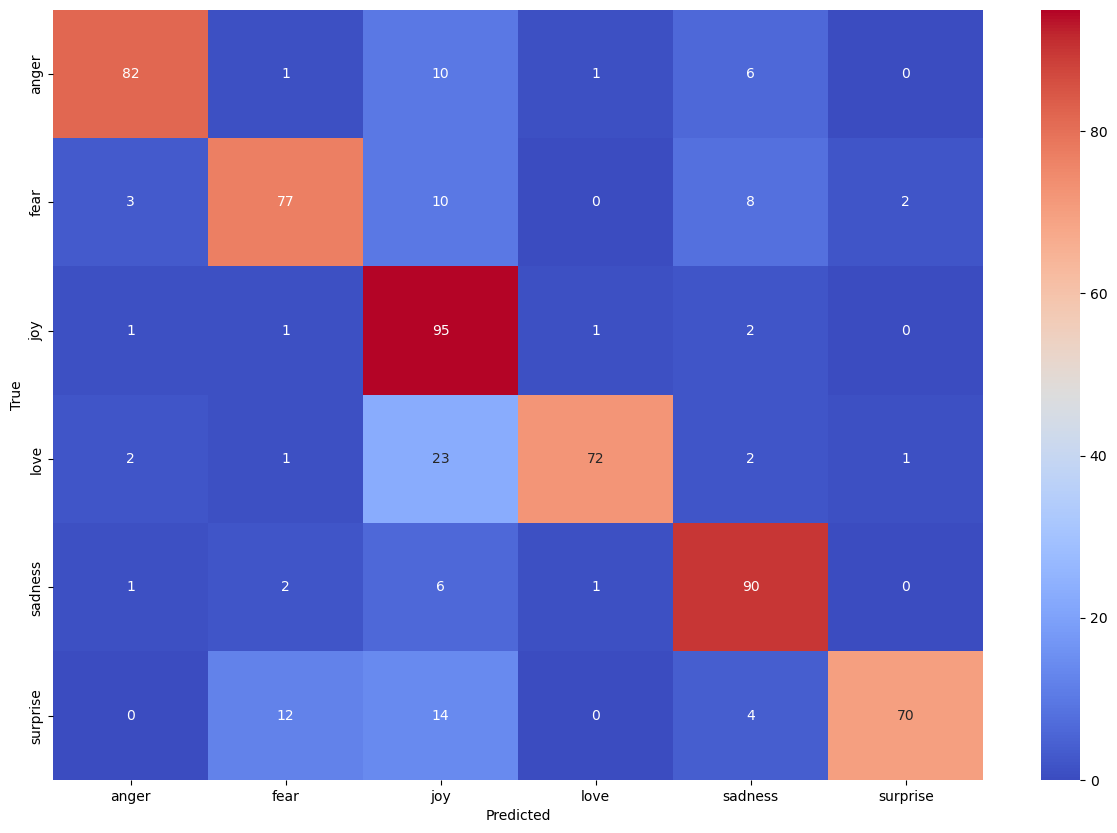

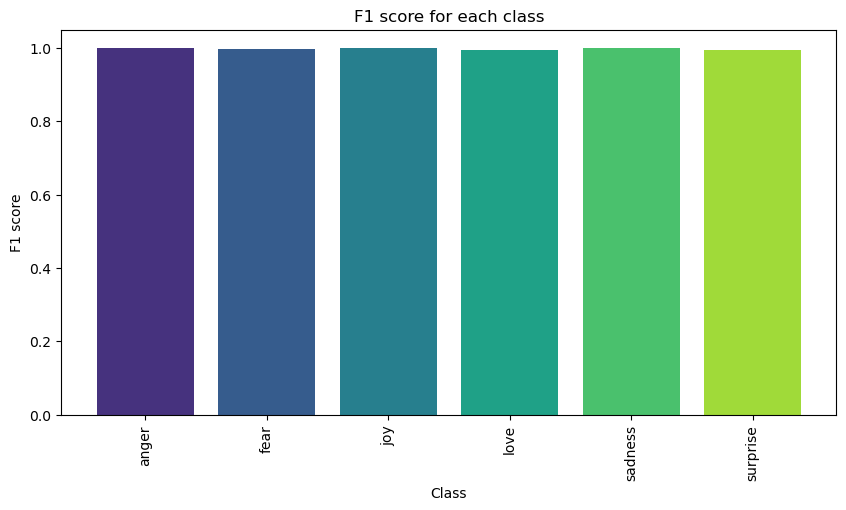

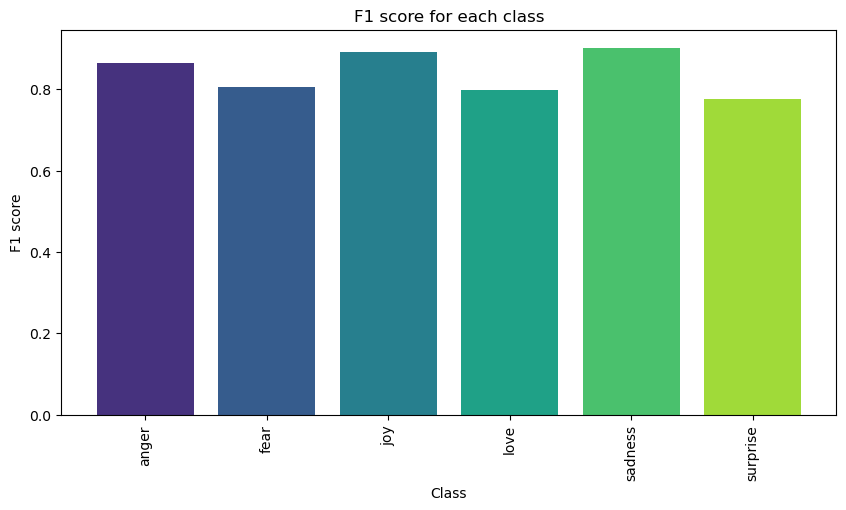

In [25]:
# training one versus rest classifier
classifier = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=777))
])

sl_classifier_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

One vs rest provides better results

# Saving best models

In [59]:
train_df, val_df, test_df = load_dataset(DatasetEnum.TwitterData, k_hot_encode=True)

In [60]:
CLASSIFIER_PATH = './checkpoints/TwitterData/'
if not os.path.exists(CLASSIFIER_PATH):
    os.makedirs(CLASSIFIER_PATH)
DT_CLASSIFIER_PATH = CLASSIFIER_PATH + 'dt_classifier.pkl'
RF_CLASSIFIER_PATH = CLASSIFIER_PATH + 'rf_classifier.pkl'
RESULTS_PATH = './results/TwitterData/'

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                1.00                0.99                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            1.00                0.99                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

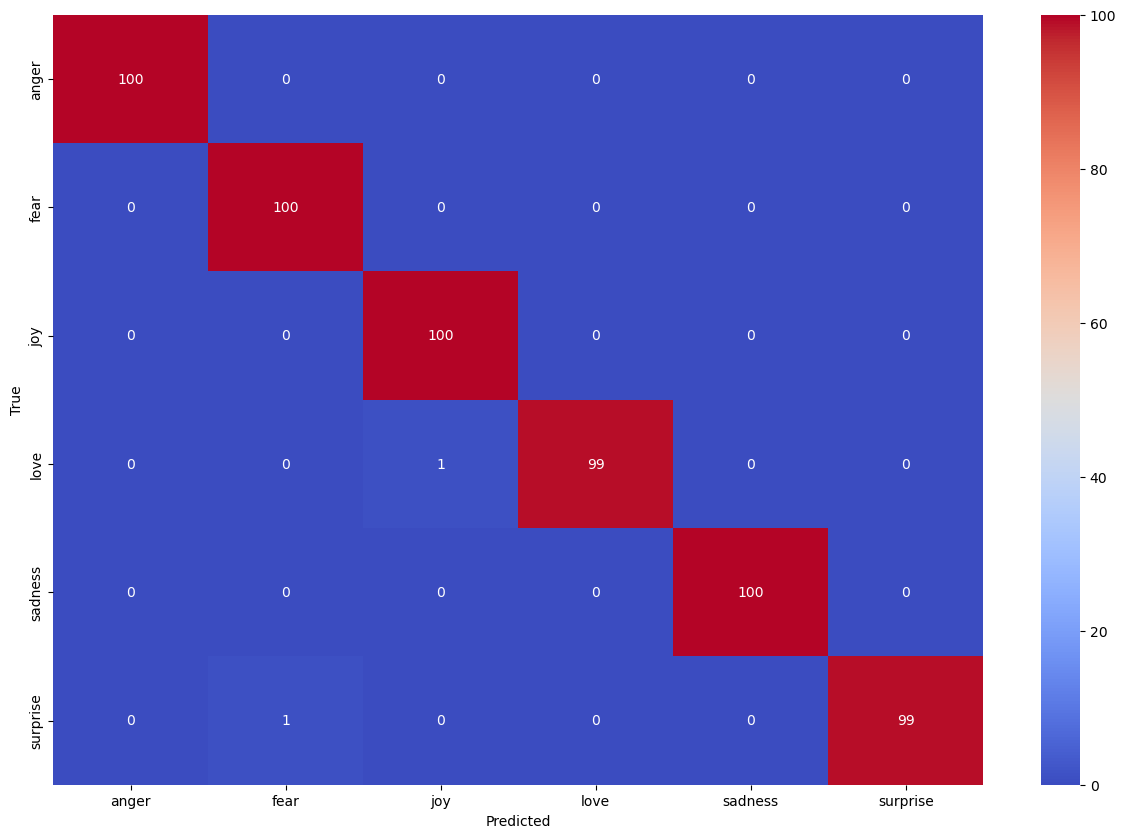

Val confusion matrix


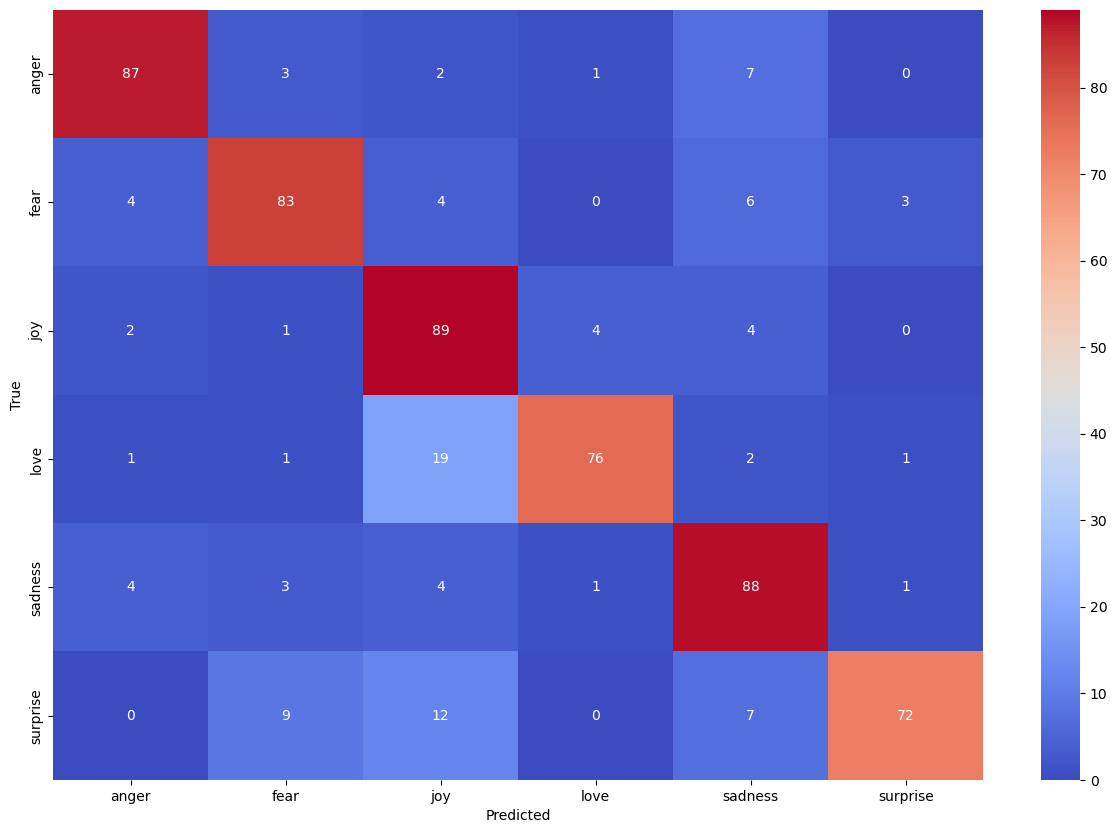

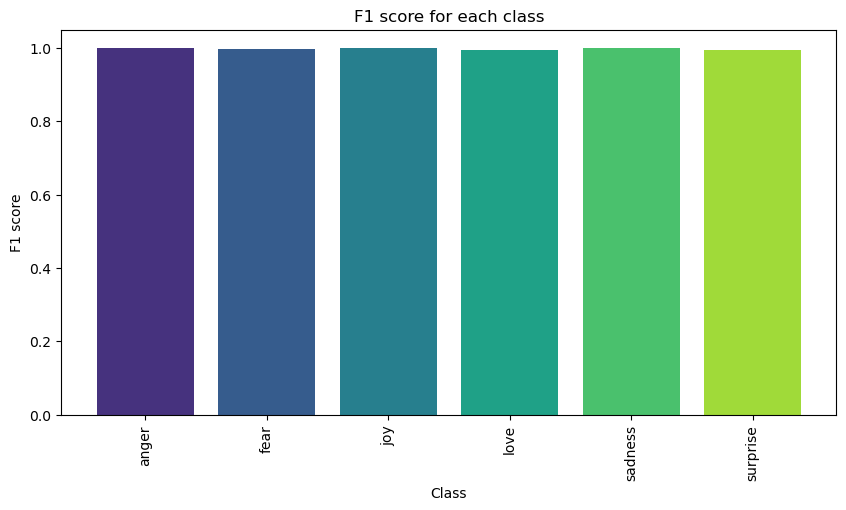

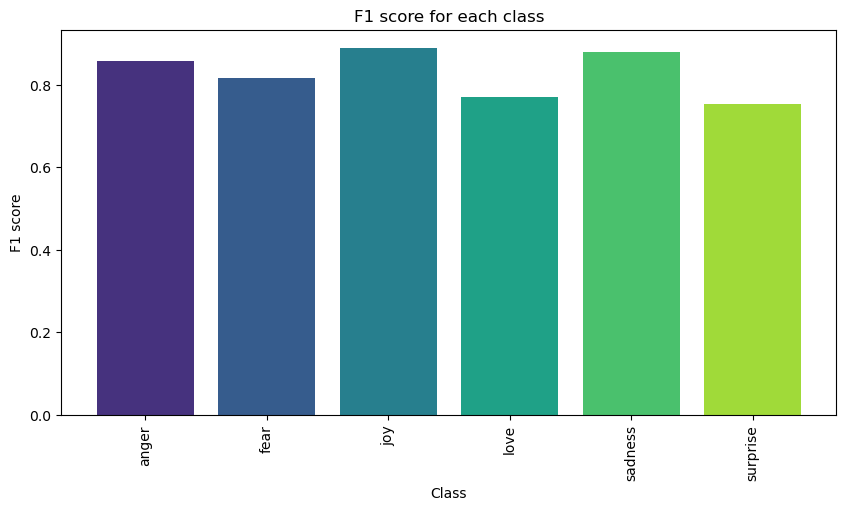

In [61]:
# training one versus rest classifier
classifier = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(random_state=777))
])

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

# save classifier
with open(DT_CLASSIFIER_PATH, 'wb') as f:
    pickle.dump(classifier, f)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               1.00                1.00                1.00                1.00                2159
fear                                1.00                1.00                1.00                0.99                1937
joy                                 1.00                1.00                1.00                1.00                5362
love                                0.99                1.00                0.99                0.99                1304
sadness                             1.00                1.00                1.00                1.00                4666
surprise                            1.00                0.99                0.99                0.99                 572
Macro avg                           1.00                1.00                1.00                0.99               1

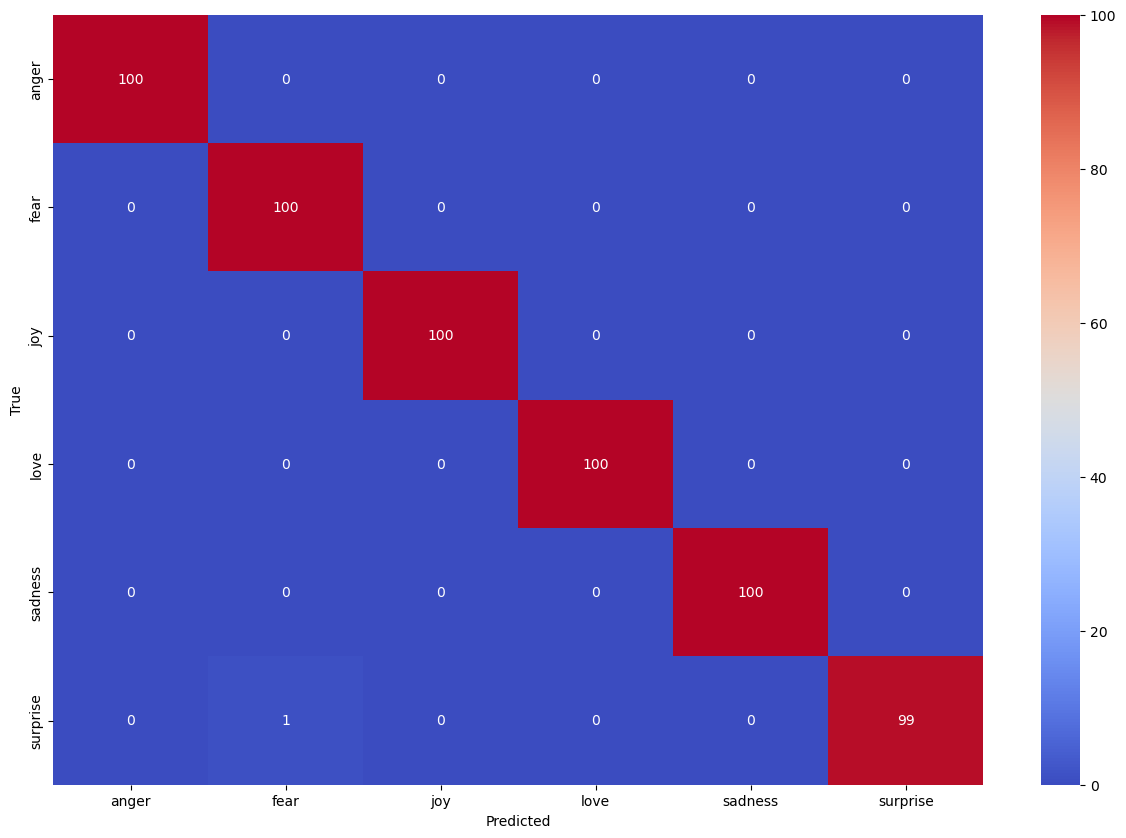

Val confusion matrix


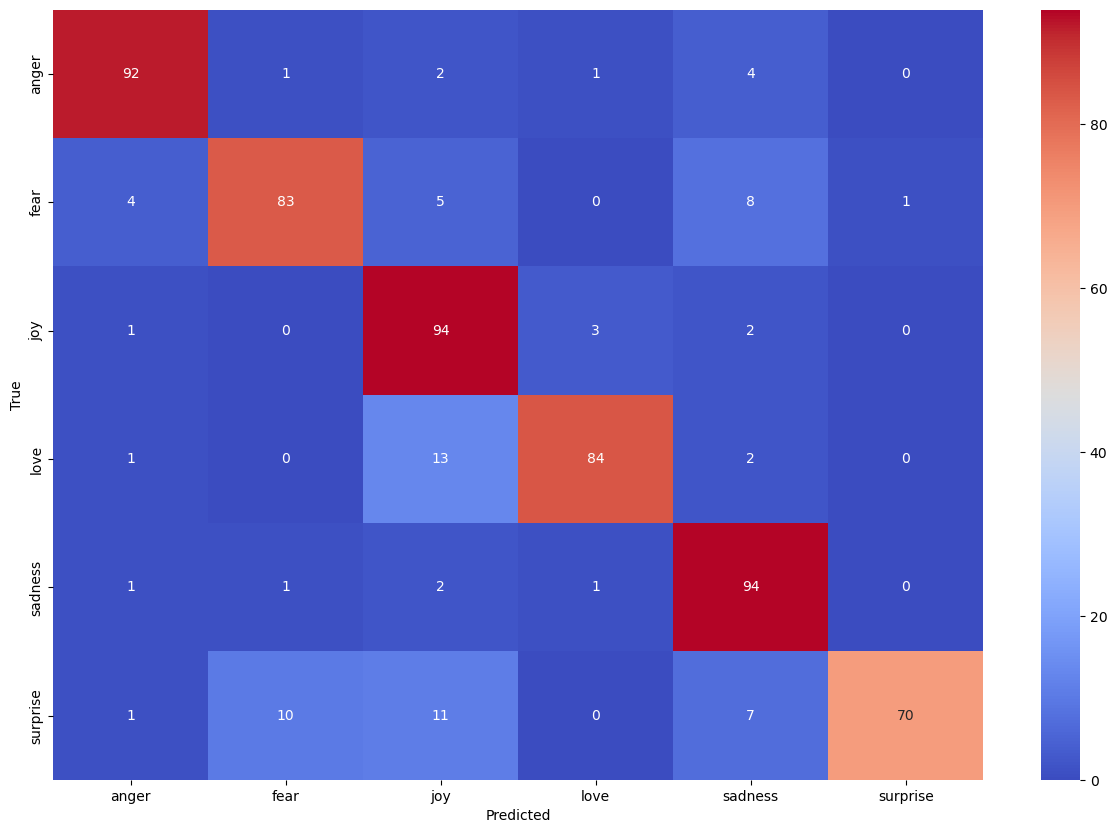

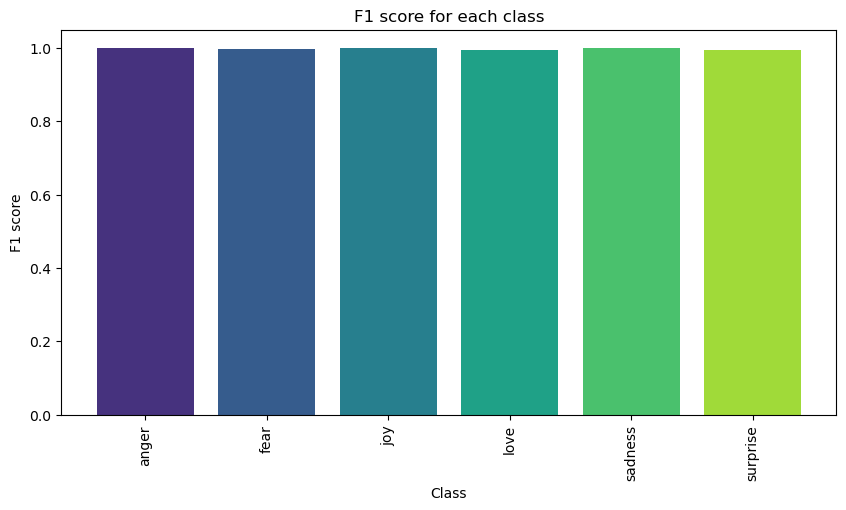

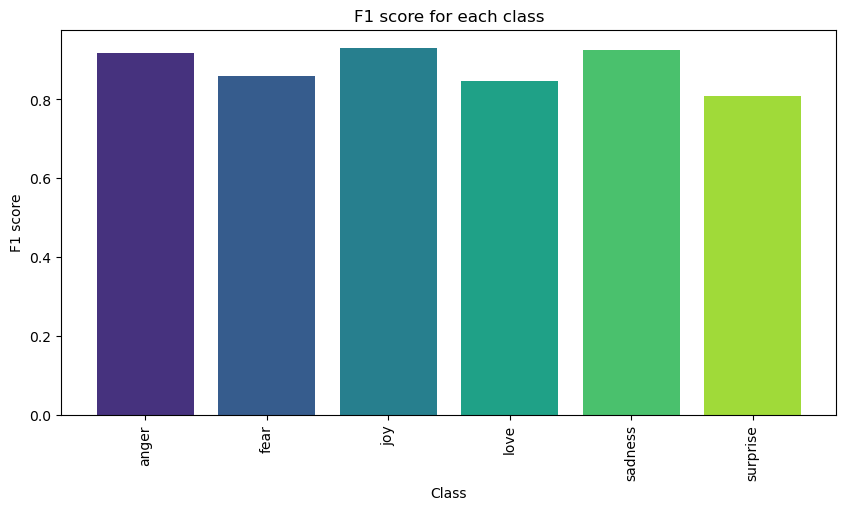

In [62]:
# training best random forest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_jobs=-1, random_state=777))
]))

OVA_clf_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

# save classifier
with open(RF_CLASSIFIER_PATH, 'wb') as f:
    pickle.dump(classifier, f)

## Features score (Decision Tree)

In [63]:
# use one vs rest with best classifier to easily extract feature importances
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(random_state=777))
]))

classifier.fit(train_df[TEXT_COLUMN], train_df[LABELS].idxmax(axis=1))

OneVsRestClassifier(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('clf',
                                               DecisionTreeClassifier(random_state=777))]))

In [64]:
feature_importance = pd.DataFrame(columns=["word", "emotion", "score"])
for emotion, estimator in zip(LABELS, classifier.estimators_):
    score = estimator.named_steps['clf'].feature_importances_
    all_words = estimator.named_steps['tfidf'].get_feature_names_out()
    words = all_words[score > 0]
    score = score[score > 0]
    feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": score})], ignore_index=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_20908\2659303496.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": score})], ignore_index=True)


In [65]:
feature_importance

,word,emotion,score
0,abhorrent,anger,0.000534
1,about,anger,0.000527
2,acts,anger,0.000534
3,aggravated,anger,0.007247
4,agitated,anger,0.013603
...,...,...,...
1841,without,surprise,0.002726
1842,working,surprise,0.002001
1843,worthless,surprise,0.001775
1844,would,surprise,0.002056


In [66]:
# save csv
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
feature_importance.to_csv(RESULTS_PATH + 'TwitterData_dt_features.csv', index=False)

Word cloud for anger


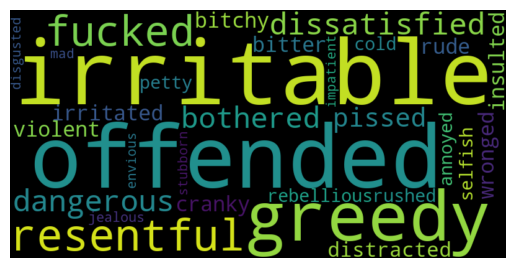

Word cloud for fear


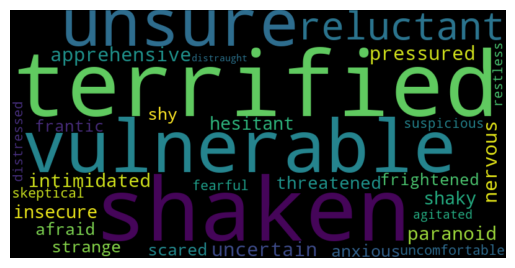

Word cloud for joy


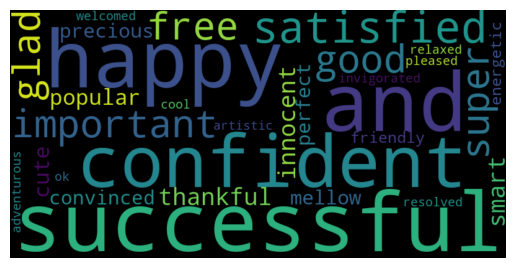

Word cloud for love


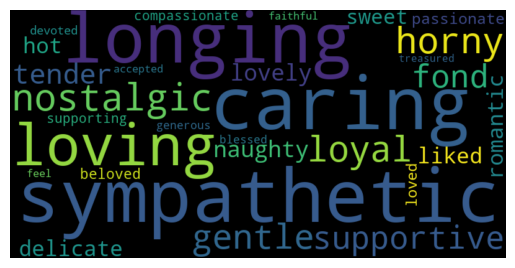

Word cloud for sadness


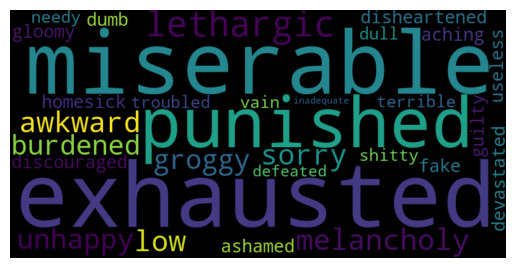

Word cloud for surprise


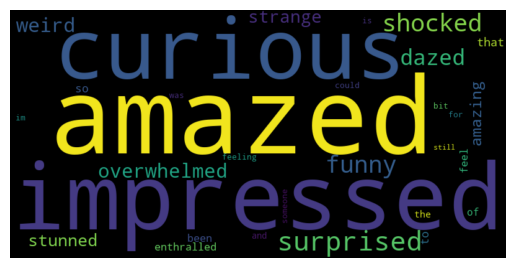

In [67]:
# word cloud of top 30 features for each class
N_TOP = 30
for label in LABELS:
    print(f'Word cloud for {label}')
    top_data = feature_importance[feature_importance['emotion'] == label].sort_values(by='score', ascending=False).head(N_TOP)
    wc = WordCloud(width=800, height=400, max_words=N_TOP).generate_from_frequencies({row['word']: row['score'] for _, row in top_data.iterrows()})
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Features score (Random Forest)

In [68]:
# load best model
with open(RF_CLASSIFIER_PATH, 'rb') as f:
    classifier = pickle.load(f)

In [69]:
feature_importance = pd.DataFrame(columns=["word", "emotion", "score"])
for emotion, estimator in zip(LABELS, classifier.estimators_):
    score = estimator.named_steps['clf'].feature_importances_
    all_words = estimator.named_steps['tfidf'].get_feature_names_out()
    words = all_words[score > 0]
    score = score[score > 0]
    feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": score})], ignore_index=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_20908\2659303496.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": score})], ignore_index=True)


In [70]:
feature_importance

,word,emotion,score
0,aa,anger,8.212183e-05
1,aac,anger,3.012922e-05
2,aaron,anger,9.184730e-05
3,ab,anger,7.813034e-08
4,abandon,anger,1.331031e-04
...,...,...,...
49729,yuuki,surprise,2.125327e-04
49730,zealand,surprise,3.733106e-04
49731,zero,surprise,4.379343e-06
49732,zimmerman,surprise,3.542130e-08


In [71]:
# save csv
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
feature_importance.to_csv(RESULTS_PATH + 'TwitterData_rf_features.csv', index=False)

Word cloud for anger


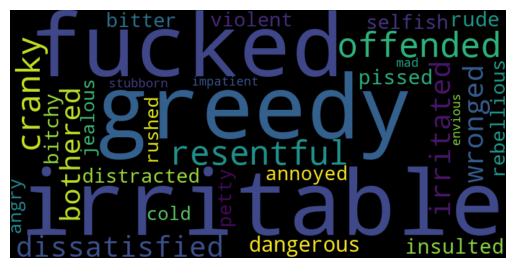

Word cloud for fear


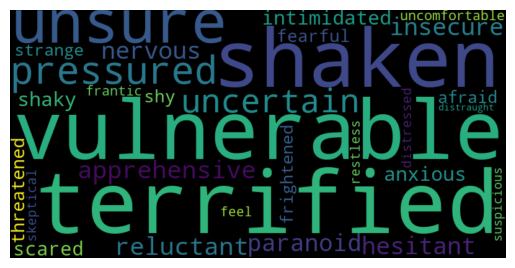

Word cloud for joy


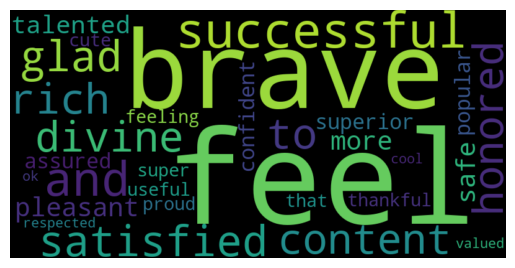

Word cloud for love


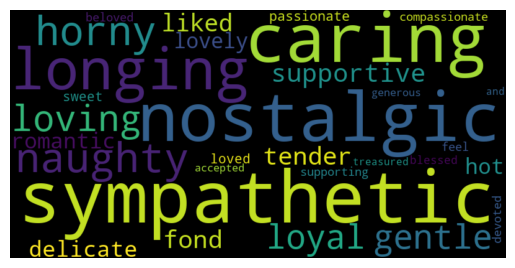

Word cloud for sadness


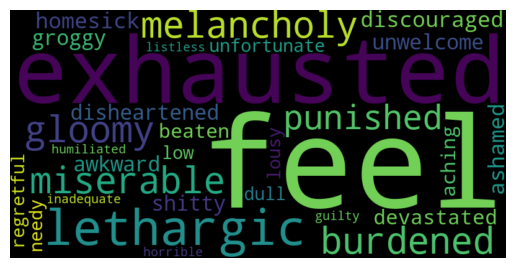

Word cloud for surprise


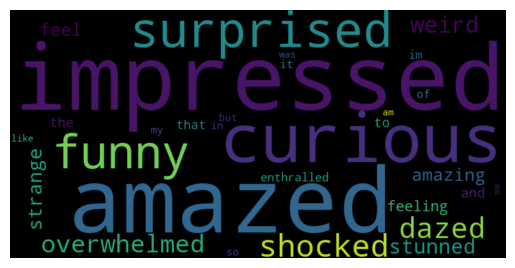

In [72]:
# word cloud of top 30 features for each class
N_TOP = 30
for label in LABELS:
    print(f'Word cloud for {label}')
    top_data = feature_importance[feature_importance['emotion'] == label].sort_values(by='score', ascending=False).head(N_TOP)
    wc = WordCloud(width=800, height=400, max_words=N_TOP).generate_from_frequencies({row['word']: row['score'] for _, row in top_data.iterrows()})
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()